# Fig. 4 - Bifurcation diagram with respect to connectivity strengths $W_{IJ}$

Here we compute the bifurcation diagrams with respect to all 9 connectivity strengths $W_{IJ}$

In [3]:
%matplotlib inline

from functools import partial
from itertools import chain, product

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
from neurolib.models.multimodel import MultiModel
from neurolib.utils.stimulus import ZeroInput

from hippocampus import HIPPOCAMPUS_NODE_DEFAULT_CONNECTIVITY, HippocampalCA3Node
from utils import run_in_parallel

plt.style.use("default_light")

## Helper function
- `compute_wrt_connectivity`: computes steady state solution of the model for a given value of connectivity `w` at the matrix position `w_position` (connectivity matrix as `[to, from]`) for two initial conditions: one is starting in the SWR state, while the second one is starting in the non-SWR state; computation is done with both backends available in the `MultiModel` framework of `neurolib`

In [4]:
def compute_wrt_connectivity(w, w_position, backend="numba"):
    results = []
    for init_c in [0, 1]:
        conn_tmp = HIPPOCAMPUS_NODE_DEFAULT_CONNECTIVITY.copy()
        conn_tmp[w_position] = w * 1e3  # scale since we use kHz
        hc = HippocampalCA3Node(
            connectivity=conn_tmp, aswr_mass_type="constant_depression"
        )
        for mass in hc:
            mass._noise_input = [ZeroInput()]
        m = MultiModel.init_node(hc)
        if init_c == 0:
            # SWR state
            m.model_instance.initial_state = np.array([0.044, 0.092, 0.0])
        else:
            # non-SWR state
            m.model_instance.initial_state = np.array([0.0, 0.0, 0.0125])
        m.params["backend"] = backend
        m.params["duration"] = 2000
        m.params["sampling_dt"] = 1.0
        m.params["dt"] = 0.05
        m.params["*aSWR*e|noise"] = 0.5
        m.run()
        arr = xr.DataArray(
            np.array(
                [
                    float(m.r_mean_EXC.T[-1]),
                    float(m.r_mean_INH.T[-1]),
                    float(m.r_mean_aSWR.T[-1]),
                ]
            ),
            dims=["node"],
            coords={"node": ["P", "B", "A"]},
        ).assign_coords(
            {
                "connectivity": w,
                "to": w_position[0],
                "from": w_position[1],
                "init_c": init_c,
            }
        )
        results.append(arr)

    return results

## Compute

Compute steady state solutions in parallel and stack them using `xr.DataArray`

In [5]:
connections = np.linspace(0.0, 15.0, 151)
to_nodes = [0, 1, 2]
from_nodes = [0, 1, 2]
init_conds = [0.0, 1.0]


def parallel_wrapper(args):
    conn, to_, from_ = args
    return compute_wrt_connectivity(
        w=conn, w_position=(to_, from_), backend="numba"
    )


res = run_in_parallel(
    parallel_wrapper, list(product(connections, to_nodes, from_nodes)), workers=6
)

bif_wrt_conn = (
    xr.concat(list(chain.from_iterable(res)), dim="new")
    .set_index(new=["connectivity", "init_c", "to", "from"])
    .unstack("new")
)

100%|██████████| 1359/1359 [06:45<00:00,  3.35it/s]


## Plot

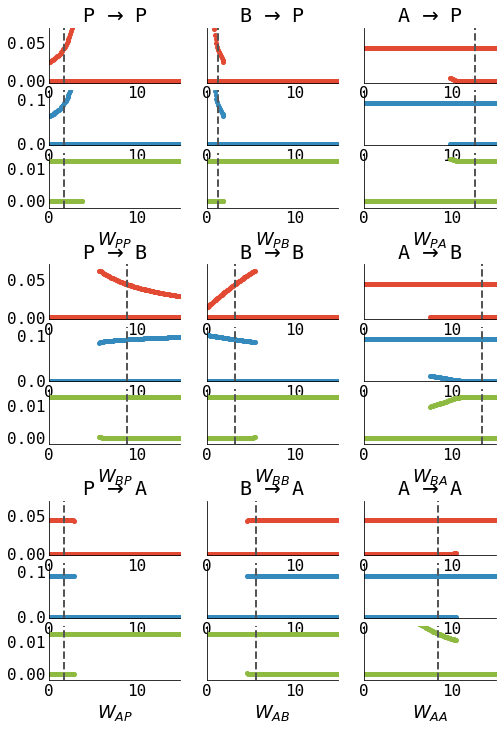

In [7]:
fig, axs = plt.subplots(
    nrows=11,
    ncols=3,
    figsize=(8, 12),
    sharex=False,
    sharey="row",
    gridspec_kw={"height_ratios": [1, 1, 1, 0.75, 1, 1, 1, 0.75, 1, 1, 1]},
)
for i in range(3):
    axs[3, i].axis("off")
    axs[7, i].axis("off")

nodes = {0: "P", 1: "B", 2: "A"}
colors = ["C0", "C1", "C5"]
maxs = [0.07, 0.12, 0.015]

for tt in bif_wrt_conn["to"]:
    for ff in bif_wrt_conn["from"]:
        for ii, node in enumerate(bif_wrt_conn["node"]):
            ax = axs[tt * 4 + ii, ff]
            ax.plot(
                bif_wrt_conn["connectivity"].values,
                bif_wrt_conn.sel({"node": node, "to": tt, "from": ff}),
                "o",
                color=colors[ii],
                markersize=4,
            )
            ax.set_xlim([0, 15])
            ax.set_ylim([-0.002, maxs[ii]])
            # ax.set_ylabel(f"{node.values} [kHz]")
            ax.axvline(
                HIPPOCAMPUS_NODE_DEFAULT_CONNECTIVITY[int(tt), int(ff)] / 1000.0,
                linestyle="--",
                color="#555555",
            )
            sns.despine(ax=ax)
            if ii == 2:
                ax.set_xlabel(
                    fr"$W_{{{nodes[int(tt.values)]}{nodes[int(ff.values)]}}}$"
                )
            if ii == 0:
                ax.set_title(fr"{nodes[int(ff.values)]} $\to$ {nodes[int(tt.values)]}")

plt.subplots_adjust(hspace=0.15, wspace=0.2)
plt.savefig("../figs/bifurcation_wrt_w.pdf", transparent=True, bbox_inches="tight")

## Repeat for `jitcdde` backend

In [8]:
connections = np.linspace(0.0, 15.0, 151)
to_nodes = [0, 1, 2]
from_nodes = [0, 1, 2]
init_conds = [0.0, 1.0]


def parallel_wrapper(args):
    conn, to_, from_ = args
    return compute_wrt_connectivity(
        w=conn, w_position=(to_, from_), backend="jitcdde"
    )


res = run_in_parallel(
    parallel_wrapper, list(product(connections, to_nodes, from_nodes)), workers=6
)

bif_wrt_conn = (
    xr.concat(list(chain.from_iterable(res)), dim="new")
    .set_index(new=["connectivity", "init_c", "to", "from"])
    .unstack("new")
)

  0%|          | 0/1359 [00:00<?, ?it/s]/Users/nikola/.virtualenvs/paper_hc/lib/python3.7/site-packages/jitcdde/_jitcdde.py:1491: UserWarning: Your input past does not begin at t=0 but at t=1.0. Values before the beginning of the past will be extrapolated. You very likely do not want this.
  warn(f"Your input past does not begin at t=0 but at t={input[0].time}. Values before the beginning of the past will be extrapolated. You very likely do not want this.")
/Users/nikola/.virtualenvs/paper_hc/lib/python3.7/site-packages/jitcdde/_jitcdde.py:1491: UserWarning: Your input past does not begin at t=0 but at t=1.0. Values before the beginning of the past will be extrapolated. You very likely do not want this.
  warn(f"Your input past does not begin at t=0 but at t={input[0].time}. Values before the beginning of the past will be extrapolated. You very likely do not want this.")
/Users/nikola/.virtualenvs/paper_hc/lib/python3.7/site-packages/jitcdde/_jitcdde.py:1491: UserWarning: Your input pa

Using default integration parameters.


  0%|          | 0/2000 [00:00<?, ?it/s]/Users/nikola/.virtualenvs/paper_hc/lib/python3.7/site-packages/jitcdde/_jitcdde.py:791: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry.
  warn("The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry.")
100%|██████████| 2000/2000 [00:00<00:00, 215978.

Using default integration parameters.


  0%|          | 0/2000 [00:00<?, ?it/s]/Users/nikola/.virtualenvs/paper_hc/lib/python3.7/site-packages/jitcdde/_jitcdde.py:791: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry.
  warn("The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry.")
100%|██████████| 2000/2000 [00:00<00:00, 223815.

Using default integration parameters.


  0%|          | 0/2000 [00:00<?, ?it/s]/Users/nikola/.virtualenvs/paper_hc/lib/python3.7/site-packages/jitcdde/_jitcdde.py:791: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry.
  warn("The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry.")
100%|██████████| 2000/2000 [00:00<00:00, 173293.

Using default integration parameters.


  0%|          | 0/2000 [00:00<?, ?it/s]/Users/nikola/.virtualenvs/paper_hc/lib/python3.7/site-packages/jitcdde/_jitcdde.py:791: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry.
  warn("The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry.")
100%|██████████| 2000/2000 [00:00<00:00, 117020.

Using default integration parameters.


  0%|          | 0/2000 [00:00<?, ?it/s]/Users/nikola/.virtualenvs/paper_hc/lib/python3.7/site-packages/jitcdde/_jitcdde.py:791: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry.
  warn("The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry.")
100%|██████████| 2000/2000 [00:00<00:00, 126517.

Using default integration parameters.


  0%|          | 0/2000 [00:00<?, ?it/s]/Users/nikola/.virtualenvs/paper_hc/lib/python3.7/site-packages/jitcdde/_jitcdde.py:791: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry.
  warn("The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry.")
100%|██████████| 2000/2000 [00:00<00:00, 98745.2

Using default integration parameters.


  0%|          | 1/1359 [00:02<1:00:17,  2.66s/it]

Using default integration parameters.


  0%|          | 2/1359 [00:02<27:10,  1.20s/it]  

Using default integration parameters.


  0%|          | 3/1359 [00:03<16:55,  1.34it/s]

Using default integration parameters.


  0%|          | 4/1359 [00:03<13:26,  1.68it/s]

Using default integration parameters.


  0%|          | 5/1359 [00:03<10:09,  2.22it/s]

Using default integration parameters.


  0%|          | 6/1359 [00:03<08:01,  2.81it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 187954.74it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 92055.04it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 260249.06it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 148281.98it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 101173.62it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 109956.85it/s]


Using default integration parameters.


  1%|          | 7/1359 [00:05<16:21,  1.38it/s]

Using default integration parameters.


  1%|          | 8/1359 [00:05<12:32,  1.80it/s]

Using default integration parameters.


  1%|          | 9/1359 [00:05<09:47,  2.30it/s]

Using default integration parameters.


  1%|          | 10/1359 [00:05<08:10,  2.75it/s]

Using default integration parameters.


  1%|          | 11/1359 [00:06<07:32,  2.98it/s]

Using default integration parameters.


  1%|          | 12/1359 [00:06<06:09,  3.64it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 224516.45it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 121117.64it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 245489.10it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 90428.59it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 196151.34it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 126053.50it/s]


Using default integration parameters.


  1%|          | 13/1359 [00:07<15:15,  1.47it/s]

Using default integration parameters.


  1%|          | 14/1359 [00:08<12:11,  1.84it/s]

Using default integration parameters.


  1%|          | 15/1359 [00:08<10:04,  2.22it/s]

Using default integration parameters.


  1%|          | 16/1359 [00:08<08:09,  2.74it/s]

Using default integration parameters.


  1%|▏         | 17/1359 [00:08<06:56,  3.22it/s]

Using default integration parameters.


  1%|▏         | 18/1359 [00:08<06:07,  3.65it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 167193.67it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 131856.96it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 196887.95it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 106825.87it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 125014.65it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 128164.27it/s]


Using default integration parameters.


  1%|▏         | 19/1359 [00:10<15:47,  1.41it/s]

Using default integration parameters.


  1%|▏         | 20/1359 [00:10<12:28,  1.79it/s]

Using default integration parameters.


  2%|▏         | 21/1359 [00:11<10:20,  2.16it/s]

Using default integration parameters.


  2%|▏         | 22/1359 [00:11<08:50,  2.52it/s]

Using default integration parameters.


  2%|▏         | 23/1359 [00:11<07:24,  3.01it/s]

Using default integration parameters.


  2%|▏         | 24/1359 [00:11<06:16,  3.55it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 206270.48it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 67872.84it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 243578.73it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 244380.59it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 235291.37it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 188856.05it/s]


Using default integration parameters.


  2%|▏         | 25/1359 [00:13<14:33,  1.53it/s]

Using default integration parameters.


  2%|▏         | 26/1359 [00:13<11:06,  2.00it/s]

Using default integration parameters.


  2%|▏         | 27/1359 [00:13<09:42,  2.29it/s]

Using default integration parameters.


  2%|▏         | 28/1359 [00:13<08:15,  2.69it/s]

Using default integration parameters.


  2%|▏         | 29/1359 [00:14<08:07,  2.73it/s]

Using default integration parameters.


  2%|▏         | 30/1359 [00:14<06:57,  3.19it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 123826.23it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 199638.45it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 186895.29it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 227642.01it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 165589.69it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 93040.32it/s]


Using default integration parameters.


  2%|▏         | 31/1359 [00:16<17:01,  1.30it/s]

Using default integration parameters.


  2%|▏         | 32/1359 [00:16<13:14,  1.67it/s]

Using default integration parameters.


  2%|▏         | 33/1359 [00:16<10:18,  2.14it/s]

Using default integration parameters.


  3%|▎         | 34/1359 [00:16<08:35,  2.57it/s]

Using default integration parameters.


  3%|▎         | 35/1359 [00:16<07:34,  2.92it/s]

Using default integration parameters.


  3%|▎         | 36/1359 [00:17<06:41,  3.30it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 193010.17it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 186219.02it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 254354.40it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 159579.36it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 131180.63it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 116264.61it/s]


Using default integration parameters.


  3%|▎         | 37/1359 [00:18<15:30,  1.42it/s]

Using default integration parameters.


  3%|▎         | 38/1359 [00:19<13:28,  1.63it/s]

Using default integration parameters.


  3%|▎         | 39/1359 [00:19<10:16,  2.14it/s]

Using default integration parameters.


  3%|▎         | 40/1359 [00:19<08:05,  2.72it/s]

Using default integration parameters.


  3%|▎         | 41/1359 [00:19<07:04,  3.11it/s]

Using default integration parameters.


  3%|▎         | 42/1359 [00:19<06:38,  3.30it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 213418.00it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 222250.11it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 199543.47it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 229516.76it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 229015.48it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 241079.66it/s]


Using default integration parameters.


  3%|▎         | 43/1359 [00:21<15:36,  1.41it/s]

Using default integration parameters.


  3%|▎         | 44/1359 [00:21<12:48,  1.71it/s]

Using default integration parameters.


  3%|▎         | 45/1359 [00:22<09:55,  2.21it/s]

Using default integration parameters.


  3%|▎         | 46/1359 [00:22<09:06,  2.40it/s]

Using default integration parameters.


  3%|▎         | 47/1359 [00:22<07:23,  2.96it/s]

Using default integration parameters.


  4%|▎         | 48/1359 [00:22<06:20,  3.44it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 198711.55it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 132510.99it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 189359.10it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 170635.42it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 177161.73it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 128883.00it/s]


Using default integration parameters.


  4%|▎         | 49/1359 [00:24<14:53,  1.47it/s]

Using default integration parameters.


  4%|▎         | 50/1359 [00:24<12:22,  1.76it/s]

Using default integration parameters.


  4%|▍         | 51/1359 [00:24<10:05,  2.16it/s]

Using default integration parameters.


  4%|▍         | 52/1359 [00:24<08:07,  2.68it/s]

Using default integration parameters.


  4%|▍         | 53/1359 [00:25<06:36,  3.30it/s]

Using default integration parameters.


  4%|▍         | 54/1359 [00:25<05:53,  3.69it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 253677.51it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 135748.98it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 209098.36it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 148179.82it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 176739.94it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 197276.89it/s]


Using default integration parameters.


  4%|▍         | 55/1359 [00:26<14:39,  1.48it/s]

Using default integration parameters.


  4%|▍         | 56/1359 [00:27<11:27,  1.89it/s]

Using default integration parameters.


  4%|▍         | 57/1359 [00:27<09:43,  2.23it/s]

Using default integration parameters.


  4%|▍         | 58/1359 [00:27<08:21,  2.59it/s]

Using default integration parameters.


  4%|▍         | 59/1359 [00:27<07:13,  3.00it/s]

Using default integration parameters.


  4%|▍         | 60/1359 [00:28<06:04,  3.57it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 184807.74it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 133226.52it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 133306.97it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 146467.06it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 148059.52it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 247802.43it/s]


Using default integration parameters.


  4%|▍         | 61/1359 [00:29<15:06,  1.43it/s]

Using default integration parameters.


  5%|▍         | 62/1359 [00:29<11:48,  1.83it/s]

Using default integration parameters.


  5%|▍         | 63/1359 [00:30<10:11,  2.12it/s]

Using default integration parameters.


  5%|▍         | 64/1359 [00:30<07:59,  2.70it/s]

Using default integration parameters.


  5%|▍         | 65/1359 [00:30<07:17,  2.96it/s]

Using default integration parameters.


  5%|▍         | 66/1359 [00:30<06:12,  3.47it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 186326.56it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 186268.64it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 217085.24it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 137439.31it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 154608.77it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 140066.92it/s]


Using default integration parameters.


  5%|▍         | 67/1359 [00:32<13:53,  1.55it/s]

Using default integration parameters.


  5%|▌         | 68/1359 [00:32<10:56,  1.97it/s]

Using default integration parameters.


  5%|▌         | 69/1359 [00:32<09:34,  2.24it/s]

Using default integration parameters.


  5%|▌         | 70/1359 [00:32<07:40,  2.80it/s]

Using default integration parameters.


  5%|▌         | 71/1359 [00:33<07:06,  3.02it/s]

Using default integration parameters.


  5%|▌         | 72/1359 [00:33<06:46,  3.16it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 225004.24it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 210864.41it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 164948.25it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 235847.05it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 227635.83it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 220196.56it/s]


Using default integration parameters.


  5%|▌         | 73/1359 [00:35<15:05,  1.42it/s]

Using default integration parameters.


  5%|▌         | 74/1359 [00:35<12:07,  1.77it/s]

Using default integration parameters.


  6%|▌         | 75/1359 [00:35<09:32,  2.24it/s]

Using default integration parameters.


  6%|▌         | 76/1359 [00:35<08:08,  2.63it/s]

Using default integration parameters.


  6%|▌         | 77/1359 [00:35<07:06,  3.01it/s]

Using default integration parameters.


  6%|▌         | 78/1359 [00:36<06:46,  3.15it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 193754.66it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 101377.81it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 166486.88it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 224696.86it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 225657.93it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 166817.96it/s]


Using default integration parameters.


  6%|▌         | 79/1359 [00:37<13:44,  1.55it/s]

Using default integration parameters.


  6%|▌         | 80/1359 [00:37<11:12,  1.90it/s]

Using default integration parameters.


  6%|▌         | 81/1359 [00:37<08:51,  2.41it/s]

Using default integration parameters.


  6%|▌         | 82/1359 [00:38<07:31,  2.83it/s]

Using default integration parameters.


  6%|▌         | 83/1359 [00:38<06:37,  3.21it/s]

Using default integration parameters.


  6%|▌         | 84/1359 [00:38<06:28,  3.28it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 135667.74it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 222026.57it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 144499.13it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 229015.48it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 206443.08it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 186165.29it/s]


Using default integration parameters.


  6%|▋         | 85/1359 [00:40<15:02,  1.41it/s]

Using default integration parameters.


  6%|▋         | 86/1359 [00:40<12:09,  1.74it/s]

Using default integration parameters.


  6%|▋         | 87/1359 [00:40<09:42,  2.18it/s]

Using default integration parameters.


  6%|▋         | 88/1359 [00:40<07:38,  2.77it/s]

Using default integration parameters.


  7%|▋         | 89/1359 [00:41<07:26,  2.84it/s]

Using default integration parameters.


  7%|▋         | 90/1359 [00:41<06:24,  3.30it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 157879.43it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 236946.25it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 237610.70it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 210046.02it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 229309.72it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 208309.11it/s]


Using default integration parameters.


  7%|▋         | 91/1359 [00:42<13:53,  1.52it/s]

Using default integration parameters.


  7%|▋         | 92/1359 [00:43<11:59,  1.76it/s]

Using default integration parameters.


  7%|▋         | 93/1359 [00:43<10:30,  2.01it/s]

Using default integration parameters.


  7%|▋         | 94/1359 [00:43<09:35,  2.20it/s]

Using default integration parameters.


  7%|▋         | 95/1359 [00:44<07:57,  2.65it/s]

Using default integration parameters.


  7%|▋         | 96/1359 [00:44<06:47,  3.10it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 153258.57it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 132687.05it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 222003.07it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 180279.99it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 131248.36it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 65832.76it/s]


Using default integration parameters.


  7%|▋         | 97/1359 [00:46<17:23,  1.21it/s]

Using default integration parameters.


  7%|▋         | 98/1359 [00:46<14:30,  1.45it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 171409.47it/s]


Using default integration parameters.


  7%|▋         | 100/1359 [00:47<10:13,  2.05it/s]

Using default integration parameters.


  7%|▋         | 101/1359 [00:47<08:39,  2.42it/s]

Using default integration parameters.


  8%|▊         | 102/1359 [00:47<08:17,  2.53it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 185839.47it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 235238.59it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 94899.12it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 134871.59it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 200339.32it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 192108.46it/s]


Using default integration parameters.


  8%|▊         | 103/1359 [00:49<16:21,  1.28it/s]

Using default integration parameters.


  8%|▊         | 104/1359 [00:49<12:44,  1.64it/s]

Using default integration parameters.


  8%|▊         | 105/1359 [00:49<09:54,  2.11it/s]

Using default integration parameters.


  8%|▊         | 106/1359 [00:50<08:58,  2.33it/s]

Using default integration parameters.


  8%|▊         | 107/1359 [00:50<08:01,  2.60it/s]

Using default integration parameters.


  8%|▊         | 108/1359 [00:50<07:17,  2.86it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 142285.91it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 173207.41it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 167060.48it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 194916.19it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 270443.23it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 235324.38it/s]


Using default integration parameters.


  8%|▊         | 109/1359 [00:52<15:55,  1.31it/s]

Using default integration parameters.


  8%|▊         | 110/1359 [00:52<12:05,  1.72it/s]

Using default integration parameters.


  8%|▊         | 111/1359 [00:52<09:34,  2.17it/s]

Using default integration parameters.


  8%|▊         | 112/1359 [00:52<07:41,  2.70it/s]

Using default integration parameters.


  8%|▊         | 113/1359 [00:53<06:48,  3.05it/s]

Using default integration parameters.


  8%|▊         | 114/1359 [00:53<05:51,  3.54it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 106542.30it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 197998.63it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 242957.92it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 216240.25it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 167956.91it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 182464.18it/s]


Using default integration parameters.


  8%|▊         | 115/1359 [00:55<15:21,  1.35it/s]

Using default integration parameters.


  9%|▊         | 116/1359 [00:55<11:41,  1.77it/s]

Using default integration parameters.


  9%|▊         | 117/1359 [00:55<09:22,  2.21it/s]

Using default integration parameters.


  9%|▊         | 118/1359 [00:55<07:46,  2.66it/s]

Using default integration parameters.


  9%|▉         | 119/1359 [00:55<06:46,  3.05it/s]

Using default integration parameters.


  9%|▉         | 120/1359 [00:56<05:57,  3.47it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 209841.10it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 222621.69it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 162444.00it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 138188.72it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 227654.36it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 146369.95it/s]


Using default integration parameters.


  9%|▉         | 121/1359 [00:57<13:24,  1.54it/s]

Using default integration parameters.


  9%|▉         | 122/1359 [00:57<10:43,  1.92it/s]

Using default integration parameters.


  9%|▉         | 123/1359 [00:58<08:47,  2.34it/s]

Using default integration parameters.


  9%|▉         | 124/1359 [00:58<07:24,  2.78it/s]

Using default integration parameters.


  9%|▉         | 125/1359 [00:58<06:38,  3.09it/s]

Using default integration parameters.


  9%|▉         | 126/1359 [00:58<05:45,  3.57it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 250159.78it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 184316.40it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 164205.61it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 177732.28it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 184758.89it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 202222.84it/s]


Using default integration parameters.


  9%|▉         | 127/1359 [01:00<12:52,  1.59it/s]

Using default integration parameters.


  9%|▉         | 128/1359 [01:00<10:23,  1.97it/s]

Using default integration parameters.


  9%|▉         | 129/1359 [01:00<08:22,  2.45it/s]

Using default integration parameters.


 10%|▉         | 130/1359 [01:00<07:54,  2.59it/s]

Using default integration parameters.


 10%|▉         | 131/1359 [01:01<06:40,  3.06it/s]

Using default integration parameters.


 10%|▉         | 132/1359 [01:01<05:46,  3.54it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 134633.48it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 203020.60it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 203626.76it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 127902.42it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 201228.39it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 133813.08it/s]


Using default integration parameters.


 10%|▉         | 133/1359 [01:02<13:51,  1.48it/s]

Using default integration parameters.


 10%|▉         | 134/1359 [01:03<12:10,  1.68it/s]

Using default integration parameters.


 10%|▉         | 135/1359 [01:03<09:23,  2.17it/s]

Using default integration parameters.


 10%|█         | 136/1359 [01:03<07:50,  2.60it/s]

Using default integration parameters.


 10%|█         | 137/1359 [01:03<06:33,  3.11it/s]

Using default integration parameters.


 10%|█         | 138/1359 [01:03<05:50,  3.49it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 192253.75it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 227093.53it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 137389.78it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 226297.12it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 172371.02it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 181093.39it/s]


Using default integration parameters.


 10%|█         | 139/1359 [01:05<13:20,  1.52it/s]

Using default integration parameters.


 10%|█         | 140/1359 [01:05<10:35,  1.92it/s]

Using default integration parameters.


 10%|█         | 141/1359 [01:05<08:44,  2.32it/s]

Using default integration parameters.


 10%|█         | 142/1359 [01:06<07:11,  2.82it/s]

Using default integration parameters.


 11%|█         | 143/1359 [01:06<06:12,  3.27it/s]

Using default integration parameters.


 11%|█         | 144/1359 [01:06<05:25,  3.73it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 169220.69it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 231806.34it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 239900.71it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 157417.25it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 205547.72it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 173583.74it/s]


Using default integration parameters.


 11%|█         | 145/1359 [01:08<13:20,  1.52it/s]

Using default integration parameters.


 11%|█         | 146/1359 [01:08<10:30,  1.92it/s]

Using default integration parameters.


 11%|█         | 147/1359 [01:08<08:16,  2.44it/s]

Using default integration parameters.


 11%|█         | 148/1359 [01:08<08:22,  2.41it/s]

Using default integration parameters.


 11%|█         | 149/1359 [01:09<07:08,  2.82it/s]

Using default integration parameters.


 11%|█         | 150/1359 [01:09<06:08,  3.28it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 176194.24it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 191827.30it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 166864.42it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 209972.42it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 201387.81it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 245252.25it/s]


Using default integration parameters.


 11%|█         | 151/1359 [01:10<15:02,  1.34it/s]

Using default integration parameters.


 11%|█         | 152/1359 [01:11<11:49,  1.70it/s]

Using default integration parameters.


 11%|█▏        | 153/1359 [01:11<09:15,  2.17it/s]

Using default integration parameters.


 11%|█▏        | 154/1359 [01:11<07:28,  2.69it/s]

Using default integration parameters.


 11%|█▏        | 155/1359 [01:11<06:29,  3.09it/s]

Using default integration parameters.


 11%|█▏        | 156/1359 [01:11<05:34,  3.60it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 114122.96it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 215468.20it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 182845.98it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 159731.29it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 185769.51it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 201465.20it/s]


Using default integration parameters.


 12%|█▏        | 157/1359 [01:13<13:10,  1.52it/s]

Using default integration parameters.


 12%|█▏        | 158/1359 [01:13<10:40,  1.87it/s]

Using default integration parameters.


 12%|█▏        | 159/1359 [01:13<08:33,  2.34it/s]

Using default integration parameters.


 12%|█▏        | 160/1359 [01:14<06:56,  2.88it/s]

Using default integration parameters.


 12%|█▏        | 161/1359 [01:14<05:55,  3.37it/s]

Using default integration parameters.


 12%|█▏        | 162/1359 [01:14<05:15,  3.80it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 239523.96it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 206972.81it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 172743.72it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 205336.40it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 124587.60it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 200497.34it/s]


Using default integration parameters.


 12%|█▏        | 163/1359 [01:16<13:32,  1.47it/s]

Using default integration parameters.


 12%|█▏        | 164/1359 [01:16<11:15,  1.77it/s]

Using default integration parameters.


 12%|█▏        | 165/1359 [01:16<08:47,  2.26it/s]

Using default integration parameters.


 12%|█▏        | 166/1359 [01:16<07:23,  2.69it/s]

Using default integration parameters.


 12%|█▏        | 167/1359 [01:16<06:26,  3.08it/s]

Using default integration parameters.


 12%|█▏        | 168/1359 [01:17<05:29,  3.61it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 257968.14it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 147861.17it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 228703.29it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 196174.27it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 153502.56it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 265068.03it/s]


Using default integration parameters.


 12%|█▏        | 169/1359 [01:18<12:12,  1.62it/s]

Using default integration parameters.


 13%|█▎        | 170/1359 [01:18<10:01,  1.98it/s]

Using default integration parameters.


 13%|█▎        | 171/1359 [01:18<08:21,  2.37it/s]

Using default integration parameters.


 13%|█▎        | 172/1359 [01:19<07:18,  2.71it/s]

Using default integration parameters.


 13%|█▎        | 173/1359 [01:19<06:17,  3.14it/s]

Using default integration parameters.


 13%|█▎        | 174/1359 [01:19<05:04,  3.89it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 253103.46it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 240823.59it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 209820.11it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 262496.73it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 188516.52it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 129551.79it/s]


Using default integration parameters.


 13%|█▎        | 175/1359 [01:20<12:07,  1.63it/s]

Using default integration parameters.


 13%|█▎        | 176/1359 [01:21<09:54,  1.99it/s]

Using default integration parameters.


 13%|█▎        | 177/1359 [01:21<08:23,  2.35it/s]

Using default integration parameters.


 13%|█▎        | 178/1359 [01:21<06:56,  2.84it/s]

Using default integration parameters.


 13%|█▎        | 179/1359 [01:21<06:12,  3.17it/s]

Using default integration parameters.


 13%|█▎        | 180/1359 [01:22<05:39,  3.47it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 113321.28it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 163597.16it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 151151.54it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 142399.43it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 224450.37it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 198195.11it/s]


Using default integration parameters.


 13%|█▎        | 181/1359 [01:23<13:27,  1.46it/s]

Using default integration parameters.


 13%|█▎        | 182/1359 [01:23<10:17,  1.91it/s]

Using default integration parameters.


 13%|█▎        | 183/1359 [01:24<09:06,  2.15it/s]

Using default integration parameters.


 14%|█▎        | 184/1359 [01:24<07:36,  2.57it/s]

Using default integration parameters.


 14%|█▎        | 185/1359 [01:24<06:24,  3.05it/s]

Using default integration parameters.


 14%|█▎        | 186/1359 [01:24<05:18,  3.69it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 264900.62it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 187091.20it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 166877.70it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 142054.60it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 255602.18it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 129708.04it/s]


Using default integration parameters.


 14%|█▍        | 187/1359 [01:26<12:12,  1.60it/s]

Using default integration parameters.


 14%|█▍        | 188/1359 [01:26<09:32,  2.04it/s]

Using default integration parameters.


 14%|█▍        | 189/1359 [01:26<08:20,  2.34it/s]

Using default integration parameters.


 14%|█▍        | 190/1359 [01:26<07:10,  2.72it/s]

Using default integration parameters.


 14%|█▍        | 191/1359 [01:27<06:16,  3.10it/s]

Using default integration parameters.


 14%|█▍        | 192/1359 [01:27<05:31,  3.52it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 202081.57it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 137968.26it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 235568.89it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 256996.05it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 138505.87it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 130951.28it/s]


Using default integration parameters.


 14%|█▍        | 193/1359 [01:28<12:33,  1.55it/s]

Using default integration parameters.


 14%|█▍        | 194/1359 [01:28<10:01,  1.94it/s]

Using default integration parameters.


 14%|█▍        | 195/1359 [01:29<07:55,  2.45it/s]

Using default integration parameters.


 14%|█▍        | 196/1359 [01:29<07:38,  2.54it/s]

Using default integration parameters.


 14%|█▍        | 197/1359 [01:29<06:16,  3.09it/s]

Using default integration parameters.


 15%|█▍        | 198/1359 [01:29<05:35,  3.46it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 235185.82it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 137437.05it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 238008.46it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 123563.58it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 243663.64it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 108312.78it/s]


Using default integration parameters.


 15%|█▍        | 199/1359 [01:31<12:01,  1.61it/s]

Using default integration parameters.


 15%|█▍        | 200/1359 [01:31<09:53,  1.95it/s]

Using default integration parameters.


 15%|█▍        | 201/1359 [01:31<08:20,  2.31it/s]

Using default integration parameters.


 15%|█▍        | 202/1359 [01:31<06:57,  2.77it/s]

Using default integration parameters.


 15%|█▍        | 203/1359 [01:32<05:47,  3.33it/s]

Using default integration parameters.


 15%|█▌        | 204/1359 [01:32<05:09,  3.73it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 150115.57it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 139169.95it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 133173.65it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 142685.24it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 136145.55it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 238373.68it/s]


Using default integration parameters.


 15%|█▌        | 205/1359 [01:33<11:43,  1.64it/s]

Using default integration parameters.


 15%|█▌        | 206/1359 [01:33<09:42,  1.98it/s]

Using default integration parameters.


 15%|█▌        | 207/1359 [01:34<07:34,  2.53it/s]

Using default integration parameters.


 15%|█▌        | 208/1359 [01:34<06:30,  2.95it/s]

Using default integration parameters.


 15%|█▌        | 209/1359 [01:34<05:44,  3.34it/s]

Using default integration parameters.


 15%|█▌        | 210/1359 [01:34<05:33,  3.45it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 239955.61it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 227839.86it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 174366.71it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 183859.90it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 259500.34it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 140048.22it/s]


Using default integration parameters.


 16%|█▌        | 211/1359 [01:36<12:26,  1.54it/s]

Using default integration parameters.


 16%|█▌        | 212/1359 [01:36<10:55,  1.75it/s]

Using default integration parameters.


 16%|█▌        | 213/1359 [01:36<08:17,  2.30it/s]

Using default integration parameters.


 16%|█▌        | 214/1359 [01:37<07:23,  2.58it/s]

Using default integration parameters.


 16%|█▌        | 215/1359 [01:37<06:24,  2.97it/s]

Using default integration parameters.


 16%|█▌        | 216/1359 [01:37<05:15,  3.63it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 196018.41it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 181304.75it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 216586.40it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 177053.29it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 219977.13it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 161272.86it/s]


Using default integration parameters.


 16%|█▌        | 217/1359 [01:38<11:59,  1.59it/s]

Using default integration parameters.


 16%|█▌        | 218/1359 [01:39<09:33,  1.99it/s]

Using default integration parameters.


 16%|█▌        | 219/1359 [01:39<08:08,  2.34it/s]

Using default integration parameters.


 16%|█▌        | 220/1359 [01:39<07:08,  2.66it/s]

Using default integration parameters.


 16%|█▋        | 221/1359 [01:39<06:08,  3.09it/s]

Using default integration parameters.


 16%|█▋        | 222/1359 [01:39<05:24,  3.51it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 161421.83it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 123160.84it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 42962.98it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 189158.41it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 147822.09it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 204142.12it/s]


Using default integration parameters.


 16%|█▋        | 223/1359 [01:41<15:01,  1.26it/s]

Using default integration parameters.


 16%|█▋        | 224/1359 [01:42<11:50,  1.60it/s]

Using default integration parameters.


 17%|█▋        | 225/1359 [01:42<10:07,  1.87it/s]

Using default integration parameters.


 17%|█▋        | 226/1359 [01:42<08:04,  2.34it/s]

Using default integration parameters.


 17%|█▋        | 227/1359 [01:42<07:04,  2.67it/s]

Using default integration parameters.


 17%|█▋        | 228/1359 [01:43<06:06,  3.08it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 174290.63it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 269107.15it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 174457.37it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 123325.61it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 262299.74it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 140397.46it/s]


Using default integration parameters.


 17%|█▋        | 229/1359 [01:44<12:16,  1.53it/s]

Using default integration parameters.


 17%|█▋        | 230/1359 [01:44<09:38,  1.95it/s]

Using default integration parameters.


 17%|█▋        | 231/1359 [01:45<08:21,  2.25it/s]

Using default integration parameters.


 17%|█▋        | 232/1359 [01:45<06:52,  2.73it/s]

Using default integration parameters.


 17%|█▋        | 233/1359 [01:45<06:11,  3.03it/s]

Using default integration parameters.


 17%|█▋        | 234/1359 [01:45<05:33,  3.37it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 123131.92it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 105003.29it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 244167.19it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 158392.18it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 173207.41it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 161773.60it/s]


Using default integration parameters.


 17%|█▋        | 235/1359 [01:47<13:14,  1.42it/s]

Using default integration parameters.


 17%|█▋        | 236/1359 [01:47<10:08,  1.85it/s]

Using default integration parameters.


 17%|█▋        | 237/1359 [01:47<08:31,  2.19it/s]

Using default integration parameters.


 18%|█▊        | 238/1359 [01:47<07:00,  2.67it/s]

Using default integration parameters.


 18%|█▊        | 239/1359 [01:48<06:32,  2.86it/s]

Using default integration parameters.


 18%|█▊        | 240/1359 [01:48<05:46,  3.23it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 229913.06it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 172921.77it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 201025.86it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 261816.73it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 165579.88it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 108594.61it/s]


Using default integration parameters.


 18%|█▊        | 241/1359 [01:50<12:36,  1.48it/s]

Using default integration parameters.


 18%|█▊        | 242/1359 [01:50<09:57,  1.87it/s]

Using default integration parameters.


 18%|█▊        | 243/1359 [01:50<08:11,  2.27it/s]

Using default integration parameters.


 18%|█▊        | 244/1359 [01:50<06:49,  2.73it/s]

Using default integration parameters.


 18%|█▊        | 245/1359 [01:50<05:59,  3.10it/s]

Using default integration parameters.


 18%|█▊        | 246/1359 [01:51<06:04,  3.06it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 251411.86it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 213108.96it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 194086.39it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 247919.61it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 223392.40it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 215700.90it/s]


Using default integration parameters.


 18%|█▊        | 247/1359 [01:52<12:42,  1.46it/s]

Using default integration parameters.


 18%|█▊        | 248/1359 [01:52<09:53,  1.87it/s]

Using default integration parameters.


 18%|█▊        | 249/1359 [01:53<07:44,  2.39it/s]

Using default integration parameters.


 18%|█▊        | 250/1359 [01:53<06:38,  2.78it/s]

Using default integration parameters.


 18%|█▊        | 251/1359 [01:53<05:39,  3.27it/s]

Using default integration parameters.


 19%|█▊        | 252/1359 [01:53<05:54,  3.12it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 220997.10it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 221463.86it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 236212.32it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 229071.76it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 258532.62it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 154035.29it/s]


Using default integration parameters.


 19%|█▊        | 253/1359 [01:55<13:25,  1.37it/s]

Using default integration parameters.


 19%|█▊        | 254/1359 [01:55<10:31,  1.75it/s]

Using default integration parameters.


 19%|█▉        | 255/1359 [01:55<08:50,  2.08it/s]

Using default integration parameters.


 19%|█▉        | 256/1359 [01:56<07:46,  2.36it/s]

Using default integration parameters.


 19%|█▉        | 257/1359 [01:56<06:29,  2.83it/s]

Using default integration parameters.


 19%|█▉        | 258/1359 [01:56<06:50,  2.69it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 149231.62it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 125896.47it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 136686.84it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 179596.81it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 151146.09it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 228336.00it/s]


Using default integration parameters.


 19%|█▉        | 259/1359 [01:58<14:09,  1.29it/s]

Using default integration parameters.


 19%|█▉        | 260/1359 [01:58<10:39,  1.72it/s]

Using default integration parameters.


 19%|█▉        | 261/1359 [01:58<08:42,  2.10it/s]

Using default integration parameters.


 19%|█▉        | 262/1359 [01:59<07:13,  2.53it/s]

Using default integration parameters.


 19%|█▉        | 263/1359 [01:59<06:08,  2.98it/s]

Using default integration parameters.


 19%|█▉        | 264/1359 [01:59<06:08,  2.97it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 229560.72it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 211395.80it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 131944.07it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 93733.75it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 225834.11it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 113108.89it/s]


Using default integration parameters.


 19%|█▉        | 265/1359 [02:01<14:12,  1.28it/s]

Using default integration parameters.


 20%|█▉        | 266/1359 [02:01<10:39,  1.71it/s]

Using default integration parameters.


 20%|█▉        | 267/1359 [02:01<09:14,  1.97it/s]

Using default integration parameters.


 20%|█▉        | 268/1359 [02:02<07:35,  2.40it/s]

Using default integration parameters.


 20%|█▉        | 269/1359 [02:02<06:32,  2.78it/s]

Using default integration parameters.


 20%|█▉        | 270/1359 [02:02<05:25,  3.34it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 238157.11it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 202403.38it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 219298.55it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 259331.87it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 238746.81it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 185839.47it/s]


Using default integration parameters.


 20%|█▉        | 271/1359 [02:04<12:46,  1.42it/s]

Using default integration parameters.


 20%|██        | 272/1359 [02:04<09:52,  1.83it/s]

Using default integration parameters.


  0%|          | 0/2000 [00:00<?, ?it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 124665.37it/s]


Using default integration parameters.


 20%|██        | 275/1359 [02:04<05:44,  3.14it/s]

Using default integration parameters.


 20%|██        | 276/1359 [02:05<05:10,  3.49it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 157060.63it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 133034.26it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 158189.07it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 120621.30it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 135942.57it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 220997.10it/s]


Using default integration parameters.


 20%|██        | 277/1359 [02:06<12:01,  1.50it/s]

Using default integration parameters.


 20%|██        | 278/1359 [02:07<09:40,  1.86it/s]

Using default integration parameters.


 21%|██        | 279/1359 [02:07<08:19,  2.16it/s]

Using default integration parameters.


 21%|██        | 280/1359 [02:07<07:31,  2.39it/s]

Using default integration parameters.


 21%|██        | 281/1359 [02:07<06:07,  2.94it/s]

Using default integration parameters.


 21%|██        | 282/1359 [02:07<04:51,  3.69it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 127853.68it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 253708.20it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 252722.20it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 190710.86it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 158565.83it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 156325.97it/s]


Using default integration parameters.


 21%|██        | 283/1359 [02:09<11:49,  1.52it/s]

Using default integration parameters.


 21%|██        | 284/1359 [02:09<09:16,  1.93it/s]

Using default integration parameters.


 21%|██        | 285/1359 [02:10<08:27,  2.12it/s]

Using default integration parameters.


 21%|██        | 286/1359 [02:10<06:40,  2.68it/s]

Using default integration parameters.


 21%|██        | 287/1359 [02:10<05:37,  3.17it/s]

Using default integration parameters.


 21%|██        | 288/1359 [02:10<04:43,  3.78it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 178983.70it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 126631.97it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 184385.27it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 231806.34it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 166265.79it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 200660.40it/s]


Using default integration parameters.


 21%|██▏       | 289/1359 [02:12<11:43,  1.52it/s]

Using default integration parameters.


 21%|██▏       | 290/1359 [02:12<08:53,  2.00it/s]

Using default integration parameters.


 21%|██▏       | 291/1359 [02:12<08:19,  2.14it/s]

Using default integration parameters.


 21%|██▏       | 292/1359 [02:12<06:37,  2.68it/s]

Using default integration parameters.


 22%|██▏       | 293/1359 [02:12<05:29,  3.23it/s]

Using default integration parameters.


 22%|██▏       | 294/1359 [02:13<04:56,  3.60it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 132093.66it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 176572.54it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 86059.07it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 157864.58it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 165302.54it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 204122.25it/s]


Using default integration parameters.


 22%|██▏       | 295/1359 [02:14<13:00,  1.36it/s]

Using default integration parameters.


 22%|██▏       | 296/1359 [02:15<10:03,  1.76it/s]

Using default integration parameters.


 22%|██▏       | 297/1359 [02:15<08:47,  2.01it/s]

Using default integration parameters.


 22%|██▏       | 298/1359 [02:15<07:34,  2.34it/s]

Using default integration parameters.


 22%|██▏       | 299/1359 [02:15<06:27,  2.74it/s]

Using default integration parameters.


 22%|██▏       | 300/1359 [02:16<05:14,  3.37it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 219706.35it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 202696.82it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 200076.51it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 183654.61it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 230570.28it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 216614.37it/s]


Using default integration parameters.


 22%|██▏       | 301/1359 [02:17<12:04,  1.46it/s]

Using default integration parameters.


 22%|██▏       | 302/1359 [02:17<09:21,  1.88it/s]

Using default integration parameters.


 22%|██▏       | 303/1359 [02:17<07:25,  2.37it/s]

Using default integration parameters.


 22%|██▏       | 304/1359 [02:18<07:21,  2.39it/s]

Using default integration parameters.


 22%|██▏       | 305/1359 [02:18<05:58,  2.94it/s]

Using default integration parameters.


 23%|██▎       | 306/1359 [02:18<04:58,  3.52it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 206397.36it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 142247.30it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 170559.10it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 147634.78it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 134499.64it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 205784.71it/s]


Using default integration parameters.


 23%|██▎       | 307/1359 [02:20<11:30,  1.52it/s]

Using default integration parameters.


 23%|██▎       | 308/1359 [02:20<09:22,  1.87it/s]

Using default integration parameters.


 23%|██▎       | 309/1359 [02:20<07:42,  2.27it/s]

Using default integration parameters.


 23%|██▎       | 310/1359 [02:20<06:46,  2.58it/s]

Using default integration parameters.


 23%|██▎       | 311/1359 [02:21<06:12,  2.82it/s]

Using default integration parameters.


 23%|██▎       | 312/1359 [02:21<05:09,  3.38it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 201571.70it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 193817.33it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 175471.87it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 118176.04it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 197877.20it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 193032.38it/s]


Using default integration parameters.


 23%|██▎       | 313/1359 [02:23<12:41,  1.37it/s]

Using default integration parameters.


 23%|██▎       | 314/1359 [02:23<10:04,  1.73it/s]

Using default integration parameters.


 23%|██▎       | 315/1359 [02:23<08:13,  2.12it/s]

Using default integration parameters.


 23%|██▎       | 316/1359 [02:23<07:00,  2.48it/s]

Using default integration parameters.


 23%|██▎       | 317/1359 [02:24<06:42,  2.59it/s]

Using default integration parameters.


 23%|██▎       | 318/1359 [02:24<05:34,  3.11it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 189141.35it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 212273.09it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 200857.39it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 206204.57it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 212606.65it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 190187.68it/s]


Using default integration parameters.


 23%|██▎       | 319/1359 [02:25<11:29,  1.51it/s]

Using default integration parameters.


 24%|██▎       | 320/1359 [02:25<09:00,  1.92it/s]

Using default integration parameters.


 24%|██▎       | 321/1359 [02:26<07:13,  2.40it/s]

Using default integration parameters.


 24%|██▎       | 322/1359 [02:26<06:31,  2.65it/s]

Using default integration parameters.


 24%|██▍       | 323/1359 [02:26<05:44,  3.00it/s]

Using default integration parameters.


 24%|██▍       | 324/1359 [02:26<05:15,  3.28it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 229648.71it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 116245.28it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 105530.36it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 143916.55it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 149644.25it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 219786.94it/s]


Using default integration parameters.


 24%|██▍       | 325/1359 [02:28<12:55,  1.33it/s]

Using default integration parameters.


 24%|██▍       | 326/1359 [02:28<10:04,  1.71it/s]

Using default integration parameters.


 24%|██▍       | 327/1359 [02:29<08:42,  1.98it/s]

Using default integration parameters.


 24%|██▍       | 328/1359 [02:29<08:11,  2.10it/s]

Using default integration parameters.


 24%|██▍       | 329/1359 [02:29<06:24,  2.68it/s]

Using default integration parameters.


 24%|██▍       | 330/1359 [02:29<05:43,  3.00it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 225094.80it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 184150.51it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 129752.18it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 178557.00it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 184860.68it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 185166.72it/s]


Using default integration parameters.


 24%|██▍       | 331/1359 [02:31<12:21,  1.39it/s]

Using default integration parameters.


 24%|██▍       | 332/1359 [02:31<09:43,  1.76it/s]

Using default integration parameters.


 25%|██▍       | 333/1359 [02:32<08:00,  2.14it/s]

Using default integration parameters.


 25%|██▍       | 334/1359 [02:32<06:46,  2.52it/s]

Using default integration parameters.


 25%|██▍       | 335/1359 [02:32<06:39,  2.56it/s]

Using default integration parameters.


 25%|██▍       | 336/1359 [02:32<06:02,  2.82it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 214839.11it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 144643.64it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 208936.91it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 252205.53it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 184824.02it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 125707.81it/s]


Using default integration parameters.


 25%|██▍       | 337/1359 [02:34<12:16,  1.39it/s]

Using default integration parameters.


 25%|██▍       | 338/1359 [02:34<09:28,  1.80it/s]

Using default integration parameters.


 25%|██▍       | 339/1359 [02:34<08:01,  2.12it/s]

Using default integration parameters.


 25%|██▌       | 340/1359 [02:35<06:19,  2.69it/s]

Using default integration parameters.


 25%|██▌       | 341/1359 [02:35<06:22,  2.66it/s]

Using default integration parameters.


 25%|██▌       | 342/1359 [02:35<06:56,  2.44it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 122000.15it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 167223.67it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 238495.66it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 201838.45it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 154777.08it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 115962.45it/s]


Using default integration parameters.


 25%|██▌       | 343/1359 [02:37<13:23,  1.26it/s]

Using default integration parameters.


 25%|██▌       | 344/1359 [02:37<10:07,  1.67it/s]

Using default integration parameters.


 25%|██▌       | 345/1359 [02:38<08:27,  2.00it/s]

Using default integration parameters.


 25%|██▌       | 346/1359 [02:38<07:03,  2.39it/s]

Using default integration parameters.


 26%|██▌       | 347/1359 [02:38<05:48,  2.90it/s]

Using default integration parameters.


 26%|██▌       | 348/1359 [02:38<05:44,  2.93it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 144277.94it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 152240.58it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 168747.52it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 214547.89it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 241663.06it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 201921.05it/s]


Using default integration parameters.


 26%|██▌       | 349/1359 [02:40<11:01,  1.53it/s]

Using default integration parameters.


 26%|██▌       | 350/1359 [02:40<09:25,  1.78it/s]

Using default integration parameters.


 26%|██▌       | 351/1359 [02:40<07:26,  2.26it/s]

Using default integration parameters.


 26%|██▌       | 352/1359 [02:40<06:05,  2.75it/s]

Using default integration parameters.


 26%|██▌       | 353/1359 [02:41<05:07,  3.27it/s]

Using default integration parameters.


 26%|██▌       | 354/1359 [02:41<04:47,  3.50it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 160127.67it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 259677.07it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 155739.71it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 110807.99it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 168988.88it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 108695.92it/s]


Using default integration parameters.


 26%|██▌       | 355/1359 [02:42<10:38,  1.57it/s]

Using default integration parameters.


 26%|██▌       | 356/1359 [02:43<08:44,  1.91it/s]

Using default integration parameters.


 26%|██▋       | 357/1359 [02:43<07:47,  2.14it/s]

Using default integration parameters.


 26%|██▋       | 358/1359 [02:43<06:14,  2.67it/s]

Using default integration parameters.


 26%|██▋       | 359/1359 [02:43<05:19,  3.13it/s]

Using default integration parameters.


 26%|██▋       | 360/1359 [02:43<04:49,  3.45it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 127372.23it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 195142.90it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 135245.59it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 174606.25it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 170899.62it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 254748.34it/s]


Using default integration parameters.


 27%|██▋       | 361/1359 [02:45<11:18,  1.47it/s]

Using default integration parameters.


 27%|██▋       | 362/1359 [02:45<08:56,  1.86it/s]

Using default integration parameters.


 27%|██▋       | 363/1359 [02:45<07:39,  2.17it/s]

Using default integration parameters.


 27%|██▋       | 364/1359 [02:46<06:15,  2.65it/s]

Using default integration parameters.


 27%|██▋       | 365/1359 [02:46<05:14,  3.16it/s]

Using default integration parameters.


 27%|██▋       | 366/1359 [02:46<04:53,  3.38it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 184332.60it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 165950.03it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 161121.08it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 188397.97it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 120760.21it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 262784.54it/s]


Using default integration parameters.


 27%|██▋       | 367/1359 [02:48<10:58,  1.51it/s]

Using default integration parameters.


 27%|██▋       | 368/1359 [02:48<08:34,  1.93it/s]

Using default integration parameters.


 27%|██▋       | 369/1359 [02:48<07:13,  2.28it/s]

Using default integration parameters.


 27%|██▋       | 370/1359 [02:48<06:06,  2.70it/s]

Using default integration parameters.


 27%|██▋       | 371/1359 [02:48<05:26,  3.03it/s]

Using default integration parameters.


 27%|██▋       | 372/1359 [02:49<04:34,  3.60it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 144668.59it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 165468.83it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 179823.96it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 149287.39it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 173720.34it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 144476.73it/s]


Using default integration parameters.


 27%|██▋       | 373/1359 [02:50<11:14,  1.46it/s]

Using default integration parameters.


 28%|██▊       | 374/1359 [02:51<09:14,  1.78it/s]

Using default integration parameters.


 28%|██▊       | 375/1359 [02:51<07:17,  2.25it/s]

Using default integration parameters.


 28%|██▊       | 376/1359 [02:51<06:19,  2.59it/s]

Using default integration parameters.


 28%|██▊       | 377/1359 [02:51<05:28,  2.99it/s]

Using default integration parameters.


 28%|██▊       | 378/1359 [02:51<04:58,  3.29it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 276313.71it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 178219.38it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 126567.01it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 203168.11it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 159297.53it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 190932.24it/s]


Using default integration parameters.


 28%|██▊       | 379/1359 [02:53<10:43,  1.52it/s]

Using default integration parameters.


 28%|██▊       | 380/1359 [02:53<08:56,  1.83it/s]

Using default integration parameters.


 28%|██▊       | 381/1359 [02:53<06:58,  2.34it/s]

Using default integration parameters.


 28%|██▊       | 382/1359 [02:54<06:05,  2.67it/s]

Using default integration parameters.


 28%|██▊       | 383/1359 [02:54<05:17,  3.07it/s]

Using default integration parameters.


 28%|██▊       | 384/1359 [02:54<04:37,  3.52it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 213060.25it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 178873.02it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 161708.11it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 225179.39it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 181144.23it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 190767.24it/s]


Using default integration parameters.


 28%|██▊       | 385/1359 [02:56<10:38,  1.53it/s]

Using default integration parameters.


 28%|██▊       | 386/1359 [02:56<08:33,  1.89it/s]

Using default integration parameters.


 28%|██▊       | 387/1359 [02:56<06:47,  2.38it/s]

Using default integration parameters.


 29%|██▊       | 388/1359 [02:56<06:20,  2.55it/s]

Using default integration parameters.


 29%|██▊       | 389/1359 [02:56<05:26,  2.97it/s]

Using default integration parameters.


 29%|██▊       | 390/1359 [02:57<04:56,  3.26it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 148402.65it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 253355.72it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 148059.52it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 150738.69it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 98389.71it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 209930.38it/s]


Using default integration parameters.


 29%|██▉       | 391/1359 [02:58<11:29,  1.40it/s]

Using default integration parameters.


 29%|██▉       | 392/1359 [02:59<09:05,  1.77it/s]

Using default integration parameters.


 29%|██▉       | 393/1359 [02:59<06:50,  2.35it/s]

Using default integration parameters.


 29%|██▉       | 394/1359 [02:59<06:10,  2.60it/s]

Using default integration parameters.


 29%|██▉       | 395/1359 [02:59<05:37,  2.85it/s]

Using default integration parameters.


 29%|██▉       | 396/1359 [02:59<04:51,  3.30it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 231008.40it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 223089.41it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 141572.71it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 158932.34it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 226474.30it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 185440.98it/s]


Using default integration parameters.


 29%|██▉       | 397/1359 [03:01<10:59,  1.46it/s]

Using default integration parameters.


 29%|██▉       | 398/1359 [03:01<08:32,  1.87it/s]

Using default integration parameters.


 29%|██▉       | 399/1359 [03:01<06:58,  2.29it/s]

Using default integration parameters.


 29%|██▉       | 400/1359 [03:02<05:46,  2.77it/s]

Using default integration parameters.


 30%|██▉       | 401/1359 [03:02<05:08,  3.11it/s]

Using default integration parameters.


 30%|██▉       | 402/1359 [03:02<04:47,  3.33it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 216045.33it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 215285.72it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 225657.93it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 151388.86it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 80932.84it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 211555.73it/s]


Using default integration parameters.


 30%|██▉       | 403/1359 [03:04<11:50,  1.35it/s]

Using default integration parameters.


 30%|██▉       | 404/1359 [03:04<09:22,  1.70it/s]

Using default integration parameters.


 30%|██▉       | 405/1359 [03:04<07:10,  2.22it/s]

Using default integration parameters.


 30%|██▉       | 406/1359 [03:05<06:35,  2.41it/s]

Using default integration parameters.


 30%|██▉       | 407/1359 [03:05<06:00,  2.64it/s]

Using default integration parameters.


 30%|███       | 408/1359 [03:05<05:00,  3.16it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 206295.85it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 184571.89it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 249527.28it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 227475.34it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 254030.89it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 127680.49it/s]


Using default integration parameters.


 30%|███       | 409/1359 [03:07<11:01,  1.44it/s]

Using default integration parameters.


 30%|███       | 410/1359 [03:07<08:39,  1.83it/s]

Using default integration parameters.


 30%|███       | 411/1359 [03:07<06:42,  2.35it/s]

Using default integration parameters.


 30%|███       | 412/1359 [03:07<06:06,  2.58it/s]

Using default integration parameters.


 30%|███       | 413/1359 [03:07<05:27,  2.89it/s]

Using default integration parameters.


 30%|███       | 414/1359 [03:08<05:00,  3.14it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 190403.52it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 236712.23it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 176539.09it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 190075.64it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 106174.16it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 241781.47it/s]


Using default integration parameters.


 31%|███       | 415/1359 [03:09<11:18,  1.39it/s]

Using default integration parameters.


 31%|███       | 416/1359 [03:10<08:45,  1.80it/s]

Using default integration parameters.


 31%|███       | 417/1359 [03:10<07:00,  2.24it/s]

Using default integration parameters.


 31%|███       | 418/1359 [03:10<05:54,  2.65it/s]

Using default integration parameters.


 31%|███       | 419/1359 [03:10<05:04,  3.09it/s]

Using default integration parameters.


 31%|███       | 420/1359 [03:10<04:57,  3.15it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 196367.14it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 241308.52it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 171189.09it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 195561.44it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 240127.33it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 148080.43it/s]


Using default integration parameters.


 31%|███       | 421/1359 [03:12<10:30,  1.49it/s]

Using default integration parameters.


 31%|███       | 422/1359 [03:12<08:21,  1.87it/s]

Using default integration parameters.


 31%|███       | 423/1359 [03:12<06:44,  2.31it/s]

Using default integration parameters.


 31%|███       | 424/1359 [03:13<05:48,  2.68it/s]

Using default integration parameters.


 31%|███▏      | 425/1359 [03:13<04:46,  3.25it/s]

Using default integration parameters.


 31%|███▏      | 426/1359 [03:13<04:36,  3.37it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 159388.33it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 209463.84it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 251630.56it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 226755.91it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 181402.76it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 186252.09it/s]


Using default integration parameters.


 31%|███▏      | 427/1359 [03:15<10:25,  1.49it/s]

Using default integration parameters.


 31%|███▏      | 428/1359 [03:15<08:03,  1.93it/s]

Using default integration parameters.


 32%|███▏      | 429/1359 [03:15<06:31,  2.37it/s]

Using default integration parameters.


 32%|███▏      | 430/1359 [03:15<05:40,  2.73it/s]

Using default integration parameters.


 32%|███▏      | 431/1359 [03:15<05:04,  3.05it/s]

Using default integration parameters.


 32%|███▏      | 432/1359 [03:16<04:37,  3.34it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 269877.68it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 208185.04it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 250600.71it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 149106.95it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 145297.54it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 185736.60it/s]


Using default integration parameters.


 32%|███▏      | 433/1359 [03:17<11:09,  1.38it/s]

Using default integration parameters.


 32%|███▏      | 434/1359 [03:18<08:36,  1.79it/s]

Using default integration parameters.


 32%|███▏      | 435/1359 [03:18<07:07,  2.16it/s]

Using default integration parameters.


 32%|███▏      | 436/1359 [03:18<05:58,  2.58it/s]

Using default integration parameters.


 32%|███▏      | 437/1359 [03:18<05:07,  3.00it/s]

Using default integration parameters.


 32%|███▏      | 438/1359 [03:18<04:42,  3.26it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 164582.55it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 226933.80it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 235264.98it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 103782.16it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 173687.97it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 255104.70it/s]


Using default integration parameters.


 32%|███▏      | 439/1359 [03:20<10:44,  1.43it/s]

Using default integration parameters.


 32%|███▏      | 440/1359 [03:20<08:25,  1.82it/s]

Using default integration parameters.


 32%|███▏      | 441/1359 [03:20<06:45,  2.26it/s]

Using default integration parameters.


 33%|███▎      | 442/1359 [03:21<05:29,  2.78it/s]

Using default integration parameters.


 33%|███▎      | 443/1359 [03:21<04:43,  3.23it/s]

Using default integration parameters.


 33%|███▎      | 444/1359 [03:21<04:18,  3.54it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 236939.55it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 174748.10it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 238577.06it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 136520.00it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 145668.43it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 248669.24it/s]


Using default integration parameters.


 33%|███▎      | 445/1359 [03:23<11:33,  1.32it/s]

Using default integration parameters.


 33%|███▎      | 446/1359 [03:23<08:44,  1.74it/s]

Using default integration parameters.


 33%|███▎      | 447/1359 [03:23<06:46,  2.24it/s]

Using default integration parameters.


 33%|███▎      | 448/1359 [03:24<06:25,  2.36it/s]

Using default integration parameters.


 33%|███▎      | 449/1359 [03:24<05:29,  2.76it/s]

Using default integration parameters.


 33%|███▎      | 450/1359 [03:24<04:34,  3.31it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 254609.16it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 111833.20it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 259267.75it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 224992.17it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 236352.08it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 153294.98it/s]


Using default integration parameters.


 33%|███▎      | 451/1359 [03:25<10:02,  1.51it/s]

Using default integration parameters.


 33%|███▎      | 452/1359 [03:26<08:08,  1.86it/s]

Using default integration parameters.


 33%|███▎      | 453/1359 [03:26<06:24,  2.36it/s]

Using default integration parameters.


 33%|███▎      | 454/1359 [03:26<05:42,  2.64it/s]

Using default integration parameters.


 33%|███▎      | 455/1359 [03:26<04:45,  3.16it/s]

Using default integration parameters.


 34%|███▎      | 456/1359 [03:27<04:22,  3.44it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 127443.83it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 257865.05it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 119847.53it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 168223.00it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 150026.97it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 128039.07it/s]


Using default integration parameters.


 34%|███▎      | 457/1359 [03:28<10:53,  1.38it/s]

Using default integration parameters.


 34%|███▎      | 458/1359 [03:29<08:57,  1.68it/s]

Using default integration parameters.


 34%|███▍      | 459/1359 [03:29<06:54,  2.17it/s]

Using default integration parameters.


 34%|███▍      | 460/1359 [03:29<06:20,  2.36it/s]

Using default integration parameters.


 34%|███▍      | 461/1359 [03:29<05:02,  2.97it/s]

Using default integration parameters.


 34%|███▍      | 462/1359 [03:29<04:48,  3.11it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 195329.20it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 171441.00it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 186795.40it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 223666.39it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 170486.30it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 236625.43it/s]


Using default integration parameters.


 34%|███▍      | 463/1359 [03:31<10:03,  1.48it/s]

Using default integration parameters.


 34%|███▍      | 464/1359 [03:31<08:29,  1.76it/s]

Using default integration parameters.


 34%|███▍      | 465/1359 [03:32<07:04,  2.10it/s]

Using default integration parameters.


 34%|███▍      | 466/1359 [03:32<05:38,  2.64it/s]

Using default integration parameters.


 34%|███▍      | 467/1359 [03:32<04:55,  3.01it/s]

Using default integration parameters.


 34%|███▍      | 468/1359 [03:32<04:11,  3.55it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 136686.84it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 222173.58it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 181819.54it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 184482.59it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 136540.00it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 191972.17it/s]


Using default integration parameters.


 35%|███▍      | 469/1359 [03:34<09:48,  1.51it/s]

Using default integration parameters.


 35%|███▍      | 470/1359 [03:34<07:54,  1.87it/s]

Using default integration parameters.


 35%|███▍      | 471/1359 [03:34<06:59,  2.11it/s]

Using default integration parameters.


 35%|███▍      | 472/1359 [03:34<05:45,  2.56it/s]

Using default integration parameters.


 35%|███▍      | 473/1359 [03:35<04:56,  2.99it/s]

Using default integration parameters.


 35%|███▍      | 474/1359 [03:35<04:14,  3.48it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 153550.33it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 200195.89it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 224264.35it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 205150.60it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 249378.92it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 201204.26it/s]


Using default integration parameters.


 35%|███▍      | 475/1359 [03:37<10:50,  1.36it/s]

Using default integration parameters.


 35%|███▌      | 476/1359 [03:37<08:17,  1.77it/s]

Using default integration parameters.


 35%|███▌      | 477/1359 [03:37<07:02,  2.09it/s]

Using default integration parameters.


 35%|███▌      | 478/1359 [03:37<05:59,  2.45it/s]

Using default integration parameters.


 35%|███▌      | 479/1359 [03:37<04:57,  2.95it/s]

Using default integration parameters.


 35%|███▌      | 480/1359 [03:38<04:20,  3.38it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 161655.13it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 166262.50it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 189804.69it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 221727.28it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 208334.98it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 245338.32it/s]


Using default integration parameters.


 35%|███▌      | 481/1359 [03:39<09:41,  1.51it/s]

Using default integration parameters.


 35%|███▌      | 482/1359 [03:39<07:43,  1.89it/s]

Using default integration parameters.


 36%|███▌      | 483/1359 [03:40<07:09,  2.04it/s]

Using default integration parameters.


 36%|███▌      | 484/1359 [03:40<06:01,  2.42it/s]

Using default integration parameters.


 36%|███▌      | 485/1359 [03:40<05:08,  2.84it/s]

Using default integration parameters.


 36%|███▌      | 486/1359 [03:41<05:22,  2.70it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 177210.39it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 132739.54it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 161524.40it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 135575.65it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 153143.86it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 102927.71it/s]


Using default integration parameters.


 36%|███▌      | 487/1359 [03:42<11:43,  1.24it/s]

Using default integration parameters.


 36%|███▌      | 488/1359 [03:43<09:03,  1.60it/s]

Using default integration parameters.


 36%|███▌      | 489/1359 [03:43<07:23,  1.96it/s]

Using default integration parameters.


 36%|███▌      | 490/1359 [03:43<06:32,  2.22it/s]

Using default integration parameters.


 36%|███▌      | 491/1359 [03:43<05:28,  2.64it/s]

Using default integration parameters.


 36%|███▌      | 492/1359 [03:44<06:03,  2.39it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 158329.39it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 172939.60it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 146028.51it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 122331.06it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 120079.13it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 138389.34it/s]


Using default integration parameters.


 36%|███▋      | 493/1359 [03:46<13:54,  1.04it/s]

Using default integration parameters.


 36%|███▋      | 494/1359 [03:46<10:17,  1.40it/s]

Using default integration parameters.


 36%|███▋      | 495/1359 [03:46<08:14,  1.75it/s]

Using default integration parameters.


 36%|███▋      | 496/1359 [03:47<07:02,  2.04it/s]

Using default integration parameters.


 37%|███▋      | 497/1359 [03:47<05:30,  2.61it/s]

Using default integration parameters.


 37%|███▋      | 498/1359 [03:47<06:04,  2.36it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 139556.61it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 123106.62it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 154264.74it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 142411.52it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 165221.15it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 119032.93it/s]


Using default integration parameters.


 37%|███▋      | 499/1359 [03:49<12:09,  1.18it/s]

Using default integration parameters.


 37%|███▋      | 500/1359 [03:50<09:48,  1.46it/s]

Using default integration parameters.


 37%|███▋      | 501/1359 [03:50<07:49,  1.83it/s]

Using default integration parameters.


 37%|███▋      | 502/1359 [03:50<06:19,  2.26it/s]

Using default integration parameters.


 37%|███▋      | 503/1359 [03:50<05:09,  2.76it/s]

Using default integration parameters.


 37%|███▋      | 504/1359 [03:51<05:37,  2.54it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 167097.09it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 139507.87it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 171231.03it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 100953.23it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 110290.80it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 205784.71it/s]


Using default integration parameters.


 37%|███▋      | 505/1359 [03:52<11:41,  1.22it/s]

Using default integration parameters.


 37%|███▋      | 506/1359 [03:53<09:26,  1.51it/s]

Using default integration parameters.


 37%|███▋      | 507/1359 [03:53<07:19,  1.94it/s]

Using default integration parameters.


 37%|███▋      | 508/1359 [03:53<06:20,  2.24it/s]

Using default integration parameters.


 37%|███▋      | 509/1359 [03:53<05:18,  2.67it/s]

Using default integration parameters.


 38%|███▊      | 510/1359 [03:54<04:35,  3.09it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 207448.82it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 193665.20it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 155413.67it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 85244.02it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 62545.07it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 132416.86it/s]


Using default integration parameters.


 38%|███▊      | 511/1359 [03:56<11:27,  1.23it/s]

Using default integration parameters.


 38%|███▊      | 512/1359 [03:56<09:30,  1.48it/s]

Using default integration parameters.


 38%|███▊      | 513/1359 [03:56<07:25,  1.90it/s]

Using default integration parameters.


 38%|███▊      | 514/1359 [03:56<06:10,  2.28it/s]

Using default integration parameters.


 38%|███▊      | 515/1359 [03:57<05:06,  2.75it/s]

Using default integration parameters.


 38%|███▊      | 516/1359 [03:57<04:20,  3.24it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 247305.66it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 205507.44it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 244829.93it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 226217.79it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 179627.58it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 134452.21it/s]


Using default integration parameters.


 38%|███▊      | 517/1359 [03:58<09:09,  1.53it/s]

Using default integration parameters.


 38%|███▊      | 518/1359 [03:58<07:45,  1.81it/s]

Using default integration parameters.


 38%|███▊      | 519/1359 [03:59<06:12,  2.25it/s]

Using default integration parameters.


 38%|███▊      | 520/1359 [03:59<05:27,  2.56it/s]

Using default integration parameters.


 38%|███▊      | 521/1359 [03:59<04:33,  3.07it/s]

Using default integration parameters.


 38%|███▊      | 522/1359 [03:59<03:46,  3.70it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 211433.09it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 171602.32it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 139468.44it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 106354.54it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 213678.94it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 226291.02it/s]


Using default integration parameters.


 38%|███▊      | 523/1359 [04:01<09:33,  1.46it/s]

Using default integration parameters.


 39%|███▊      | 524/1359 [04:01<07:52,  1.77it/s]

Using default integration parameters.


 39%|███▊      | 525/1359 [04:01<06:11,  2.25it/s]

Using default integration parameters.


 39%|███▊      | 526/1359 [04:02<05:52,  2.36it/s]

Using default integration parameters.


 39%|███▉      | 527/1359 [04:02<04:43,  2.93it/s]

Using default integration parameters.


 39%|███▉      | 528/1359 [04:02<04:05,  3.38it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 209354.06it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 127202.27it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 191315.44it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 252273.79it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 232146.34it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 188326.07it/s]


Using default integration parameters.


 39%|███▉      | 529/1359 [04:04<08:58,  1.54it/s]

Using default integration parameters.


 39%|███▉      | 530/1359 [04:04<07:10,  1.93it/s]

Using default integration parameters.


 39%|███▉      | 531/1359 [04:04<05:38,  2.45it/s]

Using default integration parameters.


 39%|███▉      | 532/1359 [04:04<05:09,  2.68it/s]

Using default integration parameters.


 39%|███▉      | 533/1359 [04:04<04:36,  2.99it/s]

Using default integration parameters.


 39%|███▉      | 534/1359 [04:05<04:02,  3.40it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 258262.00it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 230468.93it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 137297.59it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 171802.65it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 251125.85it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 196004.67it/s]


Using default integration parameters.


 39%|███▉      | 535/1359 [04:06<08:49,  1.56it/s]

Using default integration parameters.


 39%|███▉      | 536/1359 [04:06<07:08,  1.92it/s]

Using default integration parameters.


 40%|███▉      | 537/1359 [04:06<05:36,  2.44it/s]

Using default integration parameters.


 40%|███▉      | 538/1359 [04:07<05:01,  2.72it/s]

Using default integration parameters.


 40%|███▉      | 539/1359 [04:07<04:29,  3.04it/s]

Using default integration parameters.


 40%|███▉      | 540/1359 [04:07<03:56,  3.46it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 274227.13it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 104378.76it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 145739.29it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 224318.32it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 186392.80it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 223988.89it/s]


Using default integration parameters.


 40%|███▉      | 541/1359 [04:09<09:31,  1.43it/s]

Using default integration parameters.


 40%|███▉      | 542/1359 [04:09<08:04,  1.68it/s]

Using default integration parameters.


 40%|███▉      | 543/1359 [04:09<06:11,  2.20it/s]

Using default integration parameters.


 40%|████      | 544/1359 [04:10<05:01,  2.71it/s]

Using default integration parameters.


 40%|████      | 545/1359 [04:10<04:07,  3.28it/s]

Using default integration parameters.


 40%|████      | 546/1359 [04:10<03:50,  3.53it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 136854.09it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 254123.24it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 250249.34it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 214619.25it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 226547.69it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 196966.54it/s]


Using default integration parameters.


 40%|████      | 547/1359 [04:11<09:03,  1.49it/s]

Using default integration parameters.


 40%|████      | 548/1359 [04:12<06:59,  1.93it/s]

Using default integration parameters.


 40%|████      | 549/1359 [04:12<05:52,  2.30it/s]

Using default integration parameters.


 40%|████      | 550/1359 [04:12<05:06,  2.64it/s]

Using default integration parameters.


 41%|████      | 551/1359 [04:12<04:14,  3.18it/s]

Using default integration parameters.


 41%|████      | 552/1359 [04:13<04:03,  3.31it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 164621.31it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 166101.18it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 93693.96it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 134389.75it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 90326.35it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 155543.34it/s]


Using default integration parameters.


 41%|████      | 553/1359 [04:14<10:09,  1.32it/s]

Using default integration parameters.


 41%|████      | 554/1359 [04:15<07:58,  1.68it/s]

Using default integration parameters.


 41%|████      | 555/1359 [04:15<06:52,  1.95it/s]

Using default integration parameters.


 41%|████      | 556/1359 [04:15<05:28,  2.45it/s]

Using default integration parameters.


 41%|████      | 557/1359 [04:15<04:38,  2.88it/s]

Using default integration parameters.


 41%|████      | 558/1359 [04:16<04:15,  3.13it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 129208.57it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 195102.06it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 198485.86it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 177120.58it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 233269.60it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 181638.44it/s]


Using default integration parameters.


 41%|████      | 559/1359 [04:17<09:06,  1.46it/s]

Using default integration parameters.


 41%|████      | 560/1359 [04:17<06:58,  1.91it/s]

Using default integration parameters.


 41%|████▏     | 561/1359 [04:18<06:04,  2.19it/s]

Using default integration parameters.


 41%|████▏     | 562/1359 [04:18<05:15,  2.53it/s]

Using default integration parameters.


 41%|████▏     | 563/1359 [04:18<04:30,  2.95it/s]

Using default integration parameters.


 42%|████▏     | 564/1359 [04:18<03:58,  3.33it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 220723.80it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 139703.03it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 227685.26it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 273333.59it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 231582.36it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 221037.86it/s]


Using default integration parameters.


 42%|████▏     | 565/1359 [04:20<09:08,  1.45it/s]

Using default integration parameters.


 42%|████▏     | 566/1359 [04:20<07:06,  1.86it/s]

Using default integration parameters.


 42%|████▏     | 567/1359 [04:20<05:46,  2.29it/s]

Using default integration parameters.


 42%|████▏     | 568/1359 [04:20<04:52,  2.71it/s]

Using default integration parameters.


 42%|████▏     | 569/1359 [04:21<04:03,  3.24it/s]

Using default integration parameters.


 42%|████▏     | 570/1359 [04:21<03:51,  3.41it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 175207.99it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 150072.60it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 181642.37it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 122391.75it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 212423.60it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 110441.81it/s]


Using default integration parameters.


 42%|████▏     | 571/1359 [04:22<09:04,  1.45it/s]

Using default integration parameters.


 42%|████▏     | 572/1359 [04:23<07:26,  1.76it/s]

Using default integration parameters.


 42%|████▏     | 573/1359 [04:23<06:14,  2.10it/s]

Using default integration parameters.


 42%|████▏     | 574/1359 [04:23<04:56,  2.64it/s]

Using default integration parameters.


 42%|████▏     | 575/1359 [04:23<04:20,  3.00it/s]

Using default integration parameters.


 42%|████▏     | 576/1359 [04:23<03:37,  3.61it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 135674.33it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 167953.55it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 251728.72it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 127525.21it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 224066.67it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 234443.08it/s]


Using default integration parameters.


 42%|████▏     | 577/1359 [04:25<08:33,  1.52it/s]

Using default integration parameters.


 43%|████▎     | 578/1359 [04:25<06:40,  1.95it/s]

Using default integration parameters.


 43%|████▎     | 579/1359 [04:25<05:40,  2.29it/s]

Using default integration parameters.


 43%|████▎     | 580/1359 [04:26<04:40,  2.78it/s]

Using default integration parameters.


 43%|████▎     | 581/1359 [04:26<04:10,  3.11it/s]

Using default integration parameters.


 43%|████▎     | 582/1359 [04:26<03:27,  3.74it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 178823.45it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 154691.45it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 153457.63it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 159719.12it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 180373.02it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 239148.39it/s]


Using default integration parameters.


 43%|████▎     | 583/1359 [04:28<08:48,  1.47it/s]

Using default integration parameters.


 43%|████▎     | 584/1359 [04:28<07:02,  1.84it/s]

Using default integration parameters.


 43%|████▎     | 585/1359 [04:28<05:53,  2.19it/s]

Using default integration parameters.


 43%|████▎     | 586/1359 [04:28<05:05,  2.53it/s]

Using default integration parameters.


 43%|████▎     | 587/1359 [04:29<04:13,  3.05it/s]

Using default integration parameters.


 43%|████▎     | 588/1359 [04:29<03:22,  3.81it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 79929.57it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 251155.93it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 127657.17it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 138611.15it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 172637.07it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 92327.59it/s]


Using default integration parameters.


 43%|████▎     | 589/1359 [04:30<08:04,  1.59it/s]

Using default integration parameters.


 43%|████▎     | 590/1359 [04:30<06:47,  1.89it/s]

Using default integration parameters.


 43%|████▎     | 591/1359 [04:31<05:29,  2.33it/s]

Using default integration parameters.


 44%|████▎     | 592/1359 [04:31<04:36,  2.78it/s]

Using default integration parameters.


 44%|████▎     | 593/1359 [04:31<03:49,  3.33it/s]

Using default integration parameters.


 44%|████▎     | 594/1359 [04:31<03:14,  3.92it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 288387.24it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 187815.87it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 262472.09it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 137023.98it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 211417.11it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 145413.40it/s]


Using default integration parameters.


 44%|████▍     | 595/1359 [04:33<08:03,  1.58it/s]

Using default integration parameters.


 44%|████▍     | 596/1359 [04:33<06:29,  1.96it/s]

Using default integration parameters.


 44%|████▍     | 597/1359 [04:33<05:11,  2.45it/s]

Using default integration parameters.


 44%|████▍     | 598/1359 [04:33<05:04,  2.50it/s]

Using default integration parameters.


 44%|████▍     | 599/1359 [04:34<04:26,  2.85it/s]

Using default integration parameters.


 44%|████▍     | 600/1359 [04:34<03:40,  3.45it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 199657.46it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 138985.49it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 90950.18it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 274200.24it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 123092.17it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 136845.15it/s]


Using default integration parameters.


 44%|████▍     | 601/1359 [04:35<08:24,  1.50it/s]

Using default integration parameters.


 44%|████▍     | 602/1359 [04:36<06:30,  1.94it/s]

Using default integration parameters.


 44%|████▍     | 603/1359 [04:36<05:24,  2.33it/s]

Using default integration parameters.


 44%|████▍     | 604/1359 [04:36<04:28,  2.81it/s]

Using default integration parameters.


 45%|████▍     | 605/1359 [04:36<03:55,  3.20it/s]

Using default integration parameters.


 45%|████▍     | 606/1359 [04:36<03:31,  3.57it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 248787.24it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 156433.84it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 142266.60it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 192531.74it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 174142.28it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 256406.90it/s]


Using default integration parameters.


 45%|████▍     | 607/1359 [04:38<08:23,  1.49it/s]

Using default integration parameters.


 45%|████▍     | 608/1359 [04:38<06:23,  1.96it/s]

Using default integration parameters.


 45%|████▍     | 609/1359 [04:38<05:41,  2.20it/s]

Using default integration parameters.


 45%|████▍     | 610/1359 [04:39<04:34,  2.73it/s]

Using default integration parameters.


 45%|████▍     | 611/1359 [04:39<03:56,  3.16it/s]

Using default integration parameters.


 45%|████▌     | 612/1359 [04:39<03:40,  3.38it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 218055.84it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 217767.14it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 160796.80it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 205946.38it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 217987.84it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 133065.91it/s]


Using default integration parameters.


 45%|████▌     | 613/1359 [04:41<08:17,  1.50it/s]

Using default integration parameters.


 45%|████▌     | 614/1359 [04:41<06:35,  1.88it/s]

Using default integration parameters.


 45%|████▌     | 615/1359 [04:41<05:13,  2.37it/s]

Using default integration parameters.


 45%|████▌     | 616/1359 [04:41<04:21,  2.84it/s]

Using default integration parameters.


 45%|████▌     | 617/1359 [04:41<03:44,  3.30it/s]

Using default integration parameters.


 45%|████▌     | 618/1359 [04:42<03:20,  3.70it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 166275.68it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 218892.26it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 99582.23it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 146081.92it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 239318.95it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 135601.95it/s]


Using default integration parameters.


 46%|████▌     | 619/1359 [04:43<07:27,  1.65it/s]

Using default integration parameters.


 46%|████▌     | 620/1359 [04:43<05:58,  2.06it/s]

Using default integration parameters.


 46%|████▌     | 621/1359 [04:43<05:01,  2.45it/s]

Using default integration parameters.


 46%|████▌     | 622/1359 [04:44<04:09,  2.96it/s]

Using default integration parameters.


 46%|████▌     | 623/1359 [04:44<03:47,  3.24it/s]

Using default integration parameters.


 46%|████▌     | 624/1359 [04:44<03:20,  3.67it/s]

Using default integration parameters.
Using default integration parameters.

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:00<00:00, 136706.89it/s]


Using default integration parameters.


  0%|          | 0/2000 [00:00<?, ?it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 135380.92it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 264583.13it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 198373.21it/s]


Using default integration parameters.


 46%|████▌     | 625/1359 [04:46<08:10,  1.50it/s]

Using default integration parameters.


 46%|████▌     | 626/1359 [04:46<06:19,  1.93it/s]

Using default integration parameters.


 46%|████▌     | 627/1359 [04:46<05:07,  2.38it/s]

Using default integration parameters.


 46%|████▌     | 628/1359 [04:46<04:20,  2.81it/s]

Using default integration parameters.


 46%|████▋     | 629/1359 [04:46<03:40,  3.31it/s]

Using default integration parameters.


 46%|████▋     | 630/1359 [04:47<03:32,  3.44it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 230045.47it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 240038.00it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 138380.20it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 135601.95it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 132283.22it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 216474.62it/s]


Using default integration parameters.


 46%|████▋     | 631/1359 [04:48<07:26,  1.63it/s]

Using default integration parameters.


 47%|████▋     | 632/1359 [04:48<06:06,  1.98it/s]

Using default integration parameters.


 47%|████▋     | 633/1359 [04:48<04:45,  2.54it/s]

Using default integration parameters.


 47%|████▋     | 634/1359 [04:49<04:40,  2.58it/s]

Using default integration parameters.


 47%|████▋     | 635/1359 [04:49<03:43,  3.24it/s]

Using default integration parameters.


 47%|████▋     | 636/1359 [04:49<03:20,  3.61it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 221873.89it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 231454.57it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 246948.92it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 211326.57it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 135025.72it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 216759.90it/s]


Using default integration parameters.


 47%|████▋     | 637/1359 [04:51<08:12,  1.47it/s]

Using default integration parameters.


 47%|████▋     | 638/1359 [04:51<06:37,  1.81it/s]

Using default integration parameters.


 47%|████▋     | 639/1359 [04:51<05:13,  2.30it/s]

Using default integration parameters.


 47%|████▋     | 640/1359 [04:51<05:03,  2.37it/s]

Using default integration parameters.


 47%|████▋     | 641/1359 [04:52<04:08,  2.89it/s]

Using default integration parameters.


 47%|████▋     | 642/1359 [04:52<03:20,  3.58it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 191058.35it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 212181.81it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 136780.45it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 114647.02it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 175178.72it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 207423.17it/s]


Using default integration parameters.


 47%|████▋     | 643/1359 [04:53<07:45,  1.54it/s]

Using default integration parameters.


 47%|████▋     | 644/1359 [04:53<06:02,  1.97it/s]

Using default integration parameters.


 47%|████▋     | 645/1359 [04:54<04:55,  2.42it/s]

Using default integration parameters.


 48%|████▊     | 646/1359 [04:54<04:37,  2.57it/s]

Using default integration parameters.


 48%|████▊     | 647/1359 [04:54<04:00,  2.97it/s]

Using default integration parameters.


 48%|████▊     | 648/1359 [04:54<03:29,  3.40it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 294937.35it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 247802.43it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 132563.34it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 251819.40it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 216944.89it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 122541.93it/s]


Using default integration parameters.


 48%|████▊     | 649/1359 [04:56<07:26,  1.59it/s]

Using default integration parameters.


 48%|████▊     | 650/1359 [04:56<06:03,  1.95it/s]

Using default integration parameters.


 48%|████▊     | 651/1359 [04:56<05:01,  2.35it/s]

Using default integration parameters.


 48%|████▊     | 652/1359 [04:56<04:11,  2.81it/s]

Using default integration parameters.


 48%|████▊     | 653/1359 [04:57<04:01,  2.92it/s]

Using default integration parameters.


 48%|████▊     | 654/1359 [04:57<03:27,  3.39it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 134542.78it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 178363.38it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 152066.71it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 113128.72it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 204181.87it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 186703.94it/s]


Using default integration parameters.


 48%|████▊     | 655/1359 [04:59<08:13,  1.43it/s]

Using default integration parameters.


 48%|████▊     | 656/1359 [04:59<06:08,  1.91it/s]

Using default integration parameters.


 48%|████▊     | 657/1359 [04:59<04:55,  2.38it/s]

Using default integration parameters.


 48%|████▊     | 658/1359 [04:59<04:19,  2.70it/s]

Using default integration parameters.


 48%|████▊     | 659/1359 [04:59<03:53,  3.00it/s]

Using default integration parameters.


 49%|████▊     | 660/1359 [04:59<03:14,  3.60it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 273788.57it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 123939.66it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 258827.77it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 137502.38it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 229146.85it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 180411.81it/s]


Using default integration parameters.


 49%|████▊     | 661/1359 [05:01<07:30,  1.55it/s]

Using default integration parameters.


 49%|████▊     | 662/1359 [05:01<05:58,  1.94it/s]

Using default integration parameters.


 49%|████▉     | 663/1359 [05:01<04:54,  2.36it/s]

Using default integration parameters.


 49%|████▉     | 664/1359 [05:02<03:57,  2.92it/s]

Using default integration parameters.


 49%|████▉     | 665/1359 [05:02<03:35,  3.22it/s]

Using default integration parameters.


 49%|████▉     | 666/1359 [05:02<02:59,  3.87it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 150760.36it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 195102.06it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 224769.11it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 220023.29it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 245489.10it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 122363.18it/s]


Using default integration parameters.


 49%|████▉     | 667/1359 [05:04<07:50,  1.47it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 84153.69it/s]


Using default integration parameters.


 49%|████▉     | 669/1359 [05:04<05:00,  2.29it/s]

Using default integration parameters.


 49%|████▉     | 670/1359 [05:04<04:28,  2.57it/s]

Using default integration parameters.


 49%|████▉     | 671/1359 [05:04<03:57,  2.89it/s]

Using default integration parameters.


 49%|████▉     | 672/1359 [05:05<03:30,  3.26it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 167047.18it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 242417.29it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 206093.11it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 198251.32it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 136435.63it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 244195.62it/s]


Using default integration parameters.


 50%|████▉     | 673/1359 [05:06<07:49,  1.46it/s]

Using default integration parameters.


 50%|████▉     | 674/1359 [05:06<06:21,  1.79it/s]

Using default integration parameters.


 50%|████▉     | 675/1359 [05:07<05:04,  2.24it/s]

Using default integration parameters.


 50%|████▉     | 676/1359 [05:07<04:36,  2.47it/s]

Using default integration parameters.


 50%|████▉     | 677/1359 [05:07<03:47,  3.00it/s]

Using default integration parameters.


 50%|████▉     | 678/1359 [05:07<03:48,  2.98it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 143785.81it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 194726.15it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 178367.17it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 263362.05it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 237449.28it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 192846.00it/s]


Using default integration parameters.


 50%|████▉     | 679/1359 [05:09<07:31,  1.51it/s]

Using default integration parameters.


 50%|█████     | 680/1359 [05:09<05:45,  1.97it/s]

Using default integration parameters.


 50%|█████     | 681/1359 [05:09<04:38,  2.43it/s]

Using default integration parameters.


 50%|█████     | 682/1359 [05:09<03:56,  2.87it/s]

Using default integration parameters.


 50%|█████     | 683/1359 [05:10<03:23,  3.32it/s]

Using default integration parameters.


 50%|█████     | 684/1359 [05:10<03:35,  3.13it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 292745.00it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 195292.82it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 106478.74it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 264800.28it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 119974.37it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 258293.81it/s]


Using default integration parameters.


 50%|█████     | 685/1359 [05:11<07:16,  1.54it/s]

Using default integration parameters.


 50%|█████     | 686/1359 [05:12<05:42,  1.96it/s]

Using default integration parameters.


 51%|█████     | 687/1359 [05:12<04:30,  2.48it/s]

Using default integration parameters.


 51%|█████     | 688/1359 [05:12<03:59,  2.80it/s]

Using default integration parameters.


 51%|█████     | 689/1359 [05:12<03:26,  3.25it/s]

Using default integration parameters.


 51%|█████     | 690/1359 [05:12<03:28,  3.21it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 239264.35it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 182901.80it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 192567.10it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 118904.70it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 180260.62it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 246571.47it/s]


Using default integration parameters.


 51%|█████     | 691/1359 [05:14<07:48,  1.43it/s]

Using default integration parameters.


 51%|█████     | 692/1359 [05:14<06:21,  1.75it/s]

Using default integration parameters.


 51%|█████     | 693/1359 [05:15<05:02,  2.20it/s]

Using default integration parameters.


 51%|█████     | 694/1359 [05:15<04:12,  2.64it/s]

Using default integration parameters.


 51%|█████     | 695/1359 [05:15<03:22,  3.28it/s]

Using default integration parameters.


 51%|█████     | 696/1359 [05:15<03:03,  3.61it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 269461.57it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 229040.49it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 248323.26it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 247802.43it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 248448.29it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 260281.36it/s]


Using default integration parameters.


 51%|█████▏    | 697/1359 [05:17<07:20,  1.50it/s]

Using default integration parameters.


 51%|█████▏    | 698/1359 [05:17<05:39,  1.95it/s]

Using default integration parameters.


 51%|█████▏    | 699/1359 [05:17<04:39,  2.36it/s]

Using default integration parameters.


 52%|█████▏    | 700/1359 [05:17<03:53,  2.82it/s]

Using default integration parameters.


 52%|█████▏    | 701/1359 [05:17<03:13,  3.41it/s]

Using default integration parameters.


 52%|█████▏    | 702/1359 [05:18<04:02,  2.71it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 193121.26it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 221026.22it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 135464.00it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 191311.07it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 195963.46it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 219533.85it/s]


Using default integration parameters.


 52%|█████▏    | 703/1359 [05:19<07:49,  1.40it/s]

Using default integration parameters.


 52%|█████▏    | 704/1359 [05:20<06:06,  1.79it/s]

Using default integration parameters.


 52%|█████▏    | 705/1359 [05:20<04:47,  2.28it/s]

Using default integration parameters.


 52%|█████▏    | 706/1359 [05:20<04:10,  2.61it/s]

Using default integration parameters.


 52%|█████▏    | 707/1359 [05:20<03:28,  3.12it/s]

Using default integration parameters.


 52%|█████▏    | 708/1359 [05:21<03:29,  3.11it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 151742.12it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 156901.99it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 127075.09it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 286037.03it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 180539.94it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 203998.15it/s]


Using default integration parameters.


 52%|█████▏    | 709/1359 [05:22<07:33,  1.43it/s]

Using default integration parameters.


 52%|█████▏    | 710/1359 [05:22<05:52,  1.84it/s]

Using default integration parameters.


 52%|█████▏    | 711/1359 [05:23<04:44,  2.28it/s]

Using default integration parameters.


 52%|█████▏    | 712/1359 [05:23<03:57,  2.73it/s]

Using default integration parameters.


 52%|█████▏    | 713/1359 [05:23<03:28,  3.09it/s]

Using default integration parameters.


 53%|█████▎    | 714/1359 [05:23<03:06,  3.45it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 173100.18it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 160103.22it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 190291.22it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 220428.00it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 215773.03it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 188005.29it/s]


Using default integration parameters.


 53%|█████▎    | 715/1359 [05:25<07:03,  1.52it/s]

Using default integration parameters.


 53%|█████▎    | 716/1359 [05:25<05:22,  1.99it/s]

Using default integration parameters.


 53%|█████▎    | 717/1359 [05:25<04:29,  2.38it/s]

Using default integration parameters.


 53%|█████▎    | 718/1359 [05:25<03:42,  2.88it/s]

Using default integration parameters.


 53%|█████▎    | 719/1359 [05:25<03:18,  3.23it/s]

Using default integration parameters.


 53%|█████▎    | 720/1359 [05:26<02:56,  3.63it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 117784.44it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 129375.96it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 235741.01it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 159436.80it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 127910.22it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 110270.50it/s]


Using default integration parameters.


 53%|█████▎    | 721/1359 [05:27<07:25,  1.43it/s]

Using default integration parameters.


 53%|█████▎    | 722/1359 [05:28<06:05,  1.74it/s]

Using default integration parameters.


 53%|█████▎    | 723/1359 [05:28<04:49,  2.20it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 105747.20it/s]


Using default integration parameters.


 53%|█████▎    | 725/1359 [05:28<03:33,  2.97it/s]

Using default integration parameters.


 53%|█████▎    | 726/1359 [05:28<03:05,  3.41it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 130015.62it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 134346.70it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 243614.10it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 145848.25it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 121103.66it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 82705.87it/s]


Using default integration parameters.


 53%|█████▎    | 727/1359 [05:30<06:10,  1.70it/s]

Using default integration parameters.


 54%|█████▎    | 728/1359 [05:30<05:09,  2.04it/s]

Using default integration parameters.


 54%|█████▎    | 729/1359 [05:30<04:16,  2.46it/s]

Using default integration parameters.


 54%|█████▎    | 730/1359 [05:30<03:37,  2.89it/s]

Using default integration parameters.


 54%|█████▍    | 731/1359 [05:31<03:18,  3.17it/s]

Using default integration parameters.


 54%|█████▍    | 732/1359 [05:31<03:02,  3.44it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 215656.54it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 163555.69it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 90490.04it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 136938.98it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 175471.87it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 265630.40it/s]


Using default integration parameters.


 54%|█████▍    | 733/1359 [05:32<06:27,  1.62it/s]

Using default integration parameters.


 54%|█████▍    | 734/1359 [05:32<05:03,  2.06it/s]

Using default integration parameters.


 54%|█████▍    | 735/1359 [05:33<04:04,  2.55it/s]

Using default integration parameters.


 54%|█████▍    | 736/1359 [05:33<03:44,  2.78it/s]

Using default integration parameters.


 54%|█████▍    | 737/1359 [05:33<03:13,  3.22it/s]

Using default integration parameters.


 54%|█████▍    | 738/1359 [05:33<02:55,  3.53it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 104793.41it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 89883.08it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 150898.67it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 150129.00it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 240182.33it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 255322.11it/s]


Using default integration parameters.


 54%|█████▍    | 739/1359 [05:35<07:09,  1.44it/s]

Using default integration parameters.


 54%|█████▍    | 740/1359 [05:35<05:23,  1.91it/s]

Using default integration parameters.


 55%|█████▍    | 741/1359 [05:35<04:24,  2.34it/s]

Using default integration parameters.


 55%|█████▍    | 742/1359 [05:35<03:39,  2.80it/s]

Using default integration parameters.


 55%|█████▍    | 743/1359 [05:36<03:07,  3.29it/s]

Using default integration parameters.


 55%|█████▍    | 744/1359 [05:36<02:42,  3.78it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 78465.67it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 161294.57it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 261270.38it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 145825.43it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 90461.74it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 88452.90it/s]


Using default integration parameters.


 55%|█████▍    | 745/1359 [05:37<06:27,  1.59it/s]

Using default integration parameters.


 55%|█████▍    | 746/1359 [05:37<05:04,  2.01it/s]

Using default integration parameters.


 55%|█████▍    | 747/1359 [05:38<04:02,  2.52it/s]

Using default integration parameters.


 55%|█████▌    | 748/1359 [05:38<03:45,  2.70it/s]

Using default integration parameters.


 55%|█████▌    | 749/1359 [05:38<03:16,  3.10it/s]

Using default integration parameters.


 55%|█████▌    | 750/1359 [05:38<02:42,  3.75it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 138611.15it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 231876.83it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 122286.48it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 98053.89it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 193589.22it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 131344.95it/s]


Using default integration parameters.


 55%|█████▌    | 751/1359 [05:40<07:09,  1.42it/s]

Using default integration parameters.


 55%|█████▌    | 752/1359 [05:40<05:23,  1.87it/s]

Using default integration parameters.


 55%|█████▌    | 753/1359 [05:40<04:21,  2.31it/s]

Using default integration parameters.


 55%|█████▌    | 754/1359 [05:41<03:55,  2.57it/s]

Using default integration parameters.


 56%|█████▌    | 755/1359 [05:41<03:39,  2.75it/s]

Using default integration parameters.


 56%|█████▌    | 756/1359 [05:41<03:05,  3.26it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 255236.66it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 244822.79it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 207423.17it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 176090.68it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 199344.31it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 154295.95it/s]


Using default integration parameters.


 56%|█████▌    | 757/1359 [05:43<06:31,  1.54it/s]

Using default integration parameters.


 56%|█████▌    | 758/1359 [05:43<05:07,  1.95it/s]

Using default integration parameters.


 56%|█████▌    | 759/1359 [05:43<04:13,  2.37it/s]

Using default integration parameters.


 56%|█████▌    | 760/1359 [05:43<03:21,  2.98it/s]

Using default integration parameters.


 56%|█████▌    | 761/1359 [05:44<03:42,  2.69it/s]

Using default integration parameters.


 56%|█████▌    | 762/1359 [05:44<02:56,  3.39it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 128784.07it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 154009.84it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 261376.21it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 279173.59it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 150977.43it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 117724.94it/s]


Using default integration parameters.


 56%|█████▌    | 763/1359 [05:45<06:44,  1.47it/s]

Using default integration parameters.


 56%|█████▌    | 764/1359 [05:45<05:07,  1.93it/s]

Using default integration parameters.


 56%|█████▋    | 765/1359 [05:46<04:20,  2.28it/s]

Using default integration parameters.


 56%|█████▋    | 766/1359 [05:46<03:24,  2.90it/s]

Using default integration parameters.


 56%|█████▋    | 767/1359 [05:46<03:27,  2.86it/s]

Using default integration parameters.


 57%|█████▋    | 768/1359 [05:46<03:06,  3.17it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 257833.35it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 244473.17it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 239496.60it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 140024.84it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 115166.44it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 165071.59it/s]


Using default integration parameters.


 57%|█████▋    | 769/1359 [05:48<06:35,  1.49it/s]

Using default integration parameters.


 57%|█████▋    | 770/1359 [05:48<05:40,  1.73it/s]

Using default integration parameters.


 57%|█████▋    | 771/1359 [05:48<04:28,  2.19it/s]

Using default integration parameters.


 57%|█████▋    | 772/1359 [05:49<03:36,  2.71it/s]

Using default integration parameters.


 57%|█████▋    | 773/1359 [05:49<03:31,  2.76it/s]

Using default integration parameters.


 57%|█████▋    | 774/1359 [05:49<03:05,  3.15it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 145519.34it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 255664.50it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 217580.74it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 106236.01it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 149396.40it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 136778.22it/s]


Using default integration parameters.


 57%|█████▋    | 775/1359 [05:51<06:27,  1.51it/s]

Using default integration parameters.


 57%|█████▋    | 776/1359 [05:51<04:55,  1.98it/s]

Using default integration parameters.


 57%|█████▋    | 777/1359 [05:51<04:19,  2.24it/s]

Using default integration parameters.


 57%|█████▋    | 778/1359 [05:51<03:42,  2.61it/s]

Using default integration parameters.


 57%|█████▋    | 779/1359 [05:51<03:05,  3.13it/s]

Using default integration parameters.


 57%|█████▋    | 780/1359 [05:52<02:45,  3.50it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 133857.92it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 121683.37it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 96706.45it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 132853.06it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 150169.31it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 136397.91it/s]


Using default integration parameters.


 57%|█████▋    | 781/1359 [05:53<06:17,  1.53it/s]

Using default integration parameters.


 58%|█████▊    | 782/1359 [05:53<04:53,  1.96it/s]

Using default integration parameters.


 58%|█████▊    | 783/1359 [05:54<04:06,  2.33it/s]

Using default integration parameters.


 58%|█████▊    | 784/1359 [05:54<03:54,  2.46it/s]

Using default integration parameters.


 58%|█████▊    | 785/1359 [05:54<03:14,  2.96it/s]

Using default integration parameters.


 58%|█████▊    | 786/1359 [05:54<02:45,  3.46it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 214641.22it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 135455.25it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 136825.07it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 125688.98it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 173053.76it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 135455.25it/s]


Using default integration parameters.


 58%|█████▊    | 787/1359 [05:56<05:48,  1.64it/s]

Using default integration parameters.


 58%|█████▊    | 788/1359 [05:56<04:44,  2.01it/s]

Using default integration parameters.


 58%|█████▊    | 789/1359 [05:56<04:09,  2.28it/s]

Using default integration parameters.


 58%|█████▊    | 790/1359 [05:56<03:29,  2.72it/s]

Using default integration parameters.


 58%|█████▊    | 791/1359 [05:57<03:03,  3.09it/s]

Using default integration parameters.


 58%|█████▊    | 792/1359 [05:57<02:43,  3.48it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 140017.83it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 247036.19it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 141934.42it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 136997.13it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 127779.68it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 216967.33it/s]


Using default integration parameters.


 58%|█████▊    | 793/1359 [05:58<06:23,  1.48it/s]

Using default integration parameters.


 58%|█████▊    | 794/1359 [05:59<05:09,  1.82it/s]

Using default integration parameters.


 58%|█████▊    | 795/1359 [05:59<04:04,  2.31it/s]

Using default integration parameters.


 59%|█████▊    | 796/1359 [05:59<03:18,  2.84it/s]

Using default integration parameters.


 59%|█████▊    | 797/1359 [05:59<03:02,  3.08it/s]

Using default integration parameters.


 59%|█████▊    | 798/1359 [05:59<02:48,  3.33it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 144516.56it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 166817.96it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 161170.61it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 144188.66it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 159655.29it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 130421.93it/s]


Using default integration parameters.


 59%|█████▉    | 799/1359 [06:01<06:24,  1.46it/s]

Using default integration parameters.


 59%|█████▉    | 800/1359 [06:01<05:17,  1.76it/s]

Using default integration parameters.


 59%|█████▉    | 801/1359 [06:02<04:07,  2.25it/s]

Using default integration parameters.


 59%|█████▉    | 802/1359 [06:02<03:26,  2.70it/s]

Using default integration parameters.


 59%|█████▉    | 803/1359 [06:02<02:49,  3.27it/s]

Using default integration parameters.


 59%|█████▉    | 804/1359 [06:02<02:44,  3.37it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 100755.59it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 114068.64it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 139006.21it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 138473.86it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 134011.89it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 133040.58it/s]


Using default integration parameters.


 59%|█████▉    | 805/1359 [06:04<06:16,  1.47it/s]

Using default integration parameters.


 59%|█████▉    | 806/1359 [06:04<04:58,  1.85it/s]

Using default integration parameters.


 59%|█████▉    | 807/1359 [06:04<03:58,  2.31it/s]

Using default integration parameters.


 59%|█████▉    | 808/1359 [06:04<03:26,  2.67it/s]

Using default integration parameters.


  0%|          | 0/2000 [00:00<?, ?it/s]

Using default integration parameters.

100%|██████████| 2000/2000 [00:00<00:00, 259765.52it/s]


 60%|█████▉    | 810/1359 [06:05<02:31,  3.63it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 263917.19it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 148182.44it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 264241.42it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 243190.35it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 137694.23it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 108755.11it/s]


Using default integration parameters.


 60%|█████▉    | 811/1359 [06:06<05:34,  1.64it/s]

Using default integration parameters.


 60%|█████▉    | 812/1359 [06:06<04:43,  1.93it/s]

Using default integration parameters.


 60%|█████▉    | 813/1359 [06:07<03:40,  2.47it/s]

Using default integration parameters.


 60%|█████▉    | 814/1359 [06:07<03:22,  2.69it/s]

Using default integration parameters.


 60%|█████▉    | 815/1359 [06:07<02:50,  3.19it/s]

Using default integration parameters.


 60%|██████    | 816/1359 [06:07<02:32,  3.56it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 135608.53it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 137288.60it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 129266.31it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 293420.83it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 259476.26it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 126021.30it/s]


Using default integration parameters.


 60%|██████    | 817/1359 [06:09<05:29,  1.64it/s]

Using default integration parameters.


 60%|██████    | 818/1359 [06:09<04:36,  1.95it/s]

Using default integration parameters.


 60%|██████    | 819/1359 [06:09<03:40,  2.45it/s]

Using default integration parameters.


 60%|██████    | 820/1359 [06:09<03:11,  2.82it/s]

Using default integration parameters.


 60%|██████    | 821/1359 [06:09<02:40,  3.35it/s]

Using default integration parameters.


 60%|██████    | 822/1359 [06:10<02:34,  3.47it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 189500.26it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 216597.59it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 240906.58it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 210325.14it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 115767.21it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 162626.65it/s]


Using default integration parameters.


 61%|██████    | 823/1359 [06:11<06:03,  1.47it/s]

Using default integration parameters.


 61%|██████    | 824/1359 [06:12<04:54,  1.82it/s]

Using default integration parameters.


 61%|██████    | 825/1359 [06:12<04:06,  2.16it/s]

Using default integration parameters.


 61%|██████    | 826/1359 [06:12<03:27,  2.57it/s]

Using default integration parameters.


 61%|██████    | 827/1359 [06:12<02:59,  2.96it/s]

Using default integration parameters.


 61%|██████    | 828/1359 [06:12<02:34,  3.43it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 179470.02it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 143402.36it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 139840.43it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 231691.10it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 222645.33it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 246970.74it/s]


Using default integration parameters.


 61%|██████    | 829/1359 [06:14<05:32,  1.59it/s]

Using default integration parameters.


 61%|██████    | 830/1359 [06:14<04:34,  1.93it/s]

Using default integration parameters.


 61%|██████    | 831/1359 [06:14<03:40,  2.40it/s]

Using default integration parameters.


 61%|██████    | 832/1359 [06:15<03:22,  2.60it/s]

Using default integration parameters.


 61%|██████▏   | 833/1359 [06:15<02:59,  2.92it/s]

Using default integration parameters.


 61%|██████▏   | 834/1359 [06:15<02:31,  3.47it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 122760.72it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 135982.23it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 224817.30it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 88746.74it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 255228.89it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 221113.61it/s]


Using default integration parameters.


 61%|██████▏   | 835/1359 [06:17<06:05,  1.44it/s]

Using default integration parameters.


 62%|██████▏   | 836/1359 [06:17<04:40,  1.87it/s]

Using default integration parameters.


 62%|██████▏   | 837/1359 [06:17<03:57,  2.20it/s]

Using default integration parameters.


 62%|██████▏   | 838/1359 [06:17<03:19,  2.62it/s]

Using default integration parameters.


 62%|██████▏   | 839/1359 [06:17<02:47,  3.10it/s]

Using default integration parameters.


 62%|██████▏   | 840/1359 [06:18<02:35,  3.33it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 178060.50it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 208226.38it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 211593.09it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 196233.93it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 161443.57it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 214729.13it/s]


Using default integration parameters.


 62%|██████▏   | 841/1359 [06:19<06:07,  1.41it/s]

Using default integration parameters.


 62%|██████▏   | 842/1359 [06:20<04:51,  1.77it/s]

Using default integration parameters.


 62%|██████▏   | 843/1359 [06:20<03:49,  2.25it/s]

Using default integration parameters.


 62%|██████▏   | 844/1359 [06:20<03:09,  2.72it/s]

Using default integration parameters.


 62%|██████▏   | 845/1359 [06:20<02:56,  2.91it/s]

Using default integration parameters.


 62%|██████▏   | 846/1359 [06:21<02:41,  3.19it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 265537.91it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 154511.94it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 242662.73it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 254061.66it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 224372.32it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 245460.37it/s]


Using default integration parameters.


 62%|██████▏   | 847/1359 [06:22<05:48,  1.47it/s]

Using default integration parameters.


 62%|██████▏   | 848/1359 [06:22<04:31,  1.88it/s]

Using default integration parameters.


 62%|██████▏   | 849/1359 [06:22<03:38,  2.33it/s]

Using default integration parameters.


 63%|██████▎   | 850/1359 [06:23<03:03,  2.77it/s]

Using default integration parameters.


 63%|██████▎   | 851/1359 [06:23<02:29,  3.39it/s]

Using default integration parameters.


 63%|██████▎   | 852/1359 [06:23<02:49,  3.00it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 167347.10it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 110072.27it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 203246.87it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 234109.40it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 211214.83it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 238685.67it/s]


Using default integration parameters.


 63%|██████▎   | 853/1359 [06:25<05:38,  1.49it/s]

Using default integration parameters.


 63%|██████▎   | 854/1359 [06:25<04:31,  1.86it/s]

Using default integration parameters.


 63%|██████▎   | 855/1359 [06:25<03:40,  2.29it/s]

Using default integration parameters.


 63%|██████▎   | 856/1359 [06:25<03:03,  2.75it/s]

Using default integration parameters.


 63%|██████▎   | 857/1359 [06:25<02:29,  3.36it/s]

Using default integration parameters.


 63%|██████▎   | 858/1359 [06:26<02:36,  3.19it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 128009.77it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 149767.15it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 204186.84it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 198237.26it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 163584.40it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 203399.64it/s]


Using default integration parameters.


 63%|██████▎   | 859/1359 [06:27<06:02,  1.38it/s]

Using default integration parameters.


 63%|██████▎   | 860/1359 [06:28<04:34,  1.82it/s]

Using default integration parameters.


 63%|██████▎   | 861/1359 [06:28<03:52,  2.14it/s]

Using default integration parameters.


 63%|██████▎   | 862/1359 [06:28<03:10,  2.61it/s]

Using default integration parameters.


 64%|██████▎   | 863/1359 [06:28<02:45,  2.99it/s]

Using default integration parameters.


 64%|██████▎   | 864/1359 [06:28<02:21,  3.49it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 264407.99it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 175233.61it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 231588.76it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 260079.62it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 200497.34it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 181453.77it/s]


Using default integration parameters.


 64%|██████▎   | 865/1359 [06:30<05:21,  1.54it/s]

Using default integration parameters.


 64%|██████▎   | 866/1359 [06:30<04:16,  1.92it/s]

Using default integration parameters.


 64%|██████▍   | 867/1359 [06:30<03:28,  2.36it/s]

Using default integration parameters.


 64%|██████▍   | 868/1359 [06:31<03:05,  2.65it/s]

Using default integration parameters.


 64%|██████▍   | 869/1359 [06:31<02:39,  3.07it/s]

Using default integration parameters.


 64%|██████▍   | 870/1359 [06:31<02:27,  3.31it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 260007.07it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 218932.25it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 161745.52it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 176907.67it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 258198.41it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 130444.24it/s]


Using default integration parameters.


 64%|██████▍   | 871/1359 [06:32<05:11,  1.57it/s]

Using default integration parameters.


 64%|██████▍   | 872/1359 [06:33<03:56,  2.06it/s]

Using default integration parameters.


 64%|██████▍   | 873/1359 [06:33<03:23,  2.39it/s]

Using default integration parameters.


 64%|██████▍   | 874/1359 [06:33<03:05,  2.62it/s]

Using default integration parameters.


 64%|██████▍   | 875/1359 [06:33<02:33,  3.14it/s]

Using default integration parameters.


 64%|██████▍   | 876/1359 [06:34<02:20,  3.45it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 123206.06it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 114962.83it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 85738.02it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 112384.56it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 141503.46it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 200540.47it/s]


Using default integration parameters.


 65%|██████▍   | 877/1359 [06:35<06:09,  1.31it/s]

Using default integration parameters.


 65%|██████▍   | 878/1359 [06:36<04:37,  1.73it/s]

Using default integration parameters.


 65%|██████▍   | 879/1359 [06:36<04:19,  1.85it/s]

Using default integration parameters.


 65%|██████▍   | 880/1359 [06:36<03:46,  2.11it/s]

Using default integration parameters.


 65%|██████▍   | 881/1359 [06:37<03:05,  2.58it/s]

Using default integration parameters.


 65%|██████▍   | 882/1359 [06:37<02:48,  2.83it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 266136.04it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 92374.36it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 90034.54it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 211087.27it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 88751.43it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 180326.49it/s]


Using default integration parameters.


 65%|██████▍   | 883/1359 [06:39<06:27,  1.23it/s]

Using default integration parameters.


 65%|██████▌   | 884/1359 [06:39<05:02,  1.57it/s]

Using default integration parameters.


 65%|██████▌   | 885/1359 [06:39<04:17,  1.84it/s]

Using default integration parameters.


 65%|██████▌   | 886/1359 [06:39<03:29,  2.26it/s]

Using default integration parameters.


 65%|██████▌   | 887/1359 [06:40<03:09,  2.49it/s]

Using default integration parameters.


 65%|██████▌   | 888/1359 [06:40<02:41,  2.91it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 90855.61it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 96112.56it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 232287.76it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 75292.90it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 148942.81it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 201857.88it/s]


Using default integration parameters.


 65%|██████▌   | 889/1359 [06:42<06:37,  1.18it/s]

Using default integration parameters.


 65%|██████▌   | 890/1359 [06:42<05:09,  1.52it/s]

Using default integration parameters.


 66%|██████▌   | 891/1359 [06:43<04:31,  1.72it/s]

Using default integration parameters.


 66%|██████▌   | 892/1359 [06:43<03:32,  2.19it/s]

Using default integration parameters.


 66%|██████▌   | 893/1359 [06:43<03:31,  2.20it/s]

Using default integration parameters.


 66%|██████▌   | 894/1359 [06:43<02:50,  2.72it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 104609.15it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 157319.83it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 258795.83it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 109915.07it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 176971.12it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 108230.33it/s]


Using default integration parameters.


 66%|██████▌   | 895/1359 [06:45<05:57,  1.30it/s]

Using default integration parameters.


 66%|██████▌   | 896/1359 [06:45<04:43,  1.63it/s]

Using default integration parameters.


 66%|██████▌   | 897/1359 [06:46<04:06,  1.88it/s]

Using default integration parameters.


 66%|██████▌   | 898/1359 [06:46<03:41,  2.08it/s]

Using default integration parameters.


 66%|██████▌   | 899/1359 [06:46<03:02,  2.53it/s]

Using default integration parameters.


 66%|██████▌   | 900/1359 [06:46<02:27,  3.10it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 89650.61it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 176974.85it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 192961.33it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 131199.10it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 132241.51it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 129914.95it/s]


Using default integration parameters.


 66%|██████▋   | 901/1359 [06:48<05:55,  1.29it/s]

Using default integration parameters.


 66%|██████▋   | 902/1359 [06:49<04:47,  1.59it/s]

Using default integration parameters.


 66%|██████▋   | 903/1359 [06:49<04:11,  1.81it/s]

Using default integration parameters.


 67%|██████▋   | 904/1359 [06:49<03:23,  2.23it/s]

Using default integration parameters.


 67%|██████▋   | 905/1359 [06:49<02:57,  2.56it/s]

Using default integration parameters.


 67%|██████▋   | 906/1359 [06:50<02:33,  2.94it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 105462.69it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 257587.91it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 191463.90it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 149815.30it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 138994.70it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 164935.27it/s]


Using default integration parameters.


 67%|██████▋   | 907/1359 [06:51<05:32,  1.36it/s]

Using default integration parameters.


 67%|██████▋   | 908/1359 [06:51<04:13,  1.78it/s]

Using default integration parameters.


 67%|██████▋   | 909/1359 [06:52<03:25,  2.18it/s]

Using default integration parameters.


 67%|██████▋   | 910/1359 [06:52<02:58,  2.52it/s]

Using default integration parameters.


 67%|██████▋   | 911/1359 [06:52<02:28,  3.01it/s]

Using default integration parameters.


 67%|██████▋   | 912/1359 [06:52<02:07,  3.51it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 95584.69it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 218180.61it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 251381.72it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 251985.82it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 93776.71it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 181997.05it/s]


Using default integration parameters.


 67%|██████▋   | 913/1359 [06:54<05:01,  1.48it/s]

Using default integration parameters.


 67%|██████▋   | 914/1359 [06:54<03:58,  1.87it/s]

Using default integration parameters.


 67%|██████▋   | 915/1359 [06:54<03:05,  2.39it/s]

Using default integration parameters.


 67%|██████▋   | 916/1359 [06:54<02:34,  2.87it/s]

Using default integration parameters.


 67%|██████▋   | 917/1359 [06:55<02:20,  3.14it/s]

Using default integration parameters.


 68%|██████▊   | 918/1359 [06:55<02:04,  3.55it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 194852.80it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 241253.00it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 263643.47it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 259902.34it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 204127.22it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 257035.42it/s]


Using default integration parameters.


 68%|██████▊   | 919/1359 [06:56<04:58,  1.47it/s]

Using default integration parameters.


 68%|██████▊   | 920/1359 [06:57<04:04,  1.80it/s]

Using default integration parameters.


 68%|██████▊   | 921/1359 [06:57<03:13,  2.26it/s]

Using default integration parameters.


 68%|██████▊   | 922/1359 [06:57<02:42,  2.69it/s]

Using default integration parameters.


 68%|██████▊   | 923/1359 [06:57<02:15,  3.21it/s]

Using default integration parameters.


 68%|██████▊   | 924/1359 [06:57<02:07,  3.41it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 221090.30it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 212042.36it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 129266.31it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 181387.07it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 215822.99it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 222214.78it/s]


Using default integration parameters.


 68%|██████▊   | 925/1359 [06:59<04:49,  1.50it/s]

Using default integration parameters.


 68%|██████▊   | 926/1359 [06:59<03:50,  1.88it/s]

Using default integration parameters.


 68%|██████▊   | 927/1359 [06:59<03:09,  2.28it/s]

Using default integration parameters.


 68%|██████▊   | 928/1359 [07:00<02:41,  2.66it/s]

Using default integration parameters.


 68%|██████▊   | 929/1359 [07:00<02:13,  3.22it/s]

Using default integration parameters.


 68%|██████▊   | 930/1359 [07:00<02:01,  3.52it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 136453.38it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 136482.24it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 191477.01it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 233724.55it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 244615.75it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 85462.87it/s]


Using default integration parameters.


 69%|██████▊   | 931/1359 [07:02<04:31,  1.58it/s]

Using default integration parameters.


 69%|██████▊   | 932/1359 [07:02<03:22,  2.11it/s]

Using default integration parameters.


 69%|██████▊   | 933/1359 [07:02<02:59,  2.37it/s]

Using default integration parameters.


 69%|██████▊   | 934/1359 [07:02<02:31,  2.81it/s]

Using default integration parameters.


 69%|██████▉   | 935/1359 [07:02<02:07,  3.33it/s]

Using default integration parameters.


 69%|██████▉   | 936/1359 [07:02<01:53,  3.74it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 287556.84it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 249090.12it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 252266.20it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 177446.55it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 212289.21it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 128990.02it/s]


Using default integration parameters.


 69%|██████▉   | 937/1359 [07:04<04:42,  1.49it/s]

Using default integration parameters.


 69%|██████▉   | 938/1359 [07:04<03:48,  1.84it/s]

Using default integration parameters.


 69%|██████▉   | 939/1359 [07:04<02:56,  2.37it/s]

Using default integration parameters.


 69%|██████▉   | 940/1359 [07:05<02:27,  2.84it/s]

Using default integration parameters.


 69%|██████▉   | 941/1359 [07:05<02:13,  3.14it/s]

Using default integration parameters.


 69%|██████▉   | 942/1359 [07:05<01:55,  3.62it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 141162.94it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 264583.13it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 254740.60it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 176135.05it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 123472.64it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 137077.72it/s]


Using default integration parameters.


 69%|██████▉   | 943/1359 [07:06<04:08,  1.68it/s]

Using default integration parameters.


 69%|██████▉   | 944/1359 [07:07<03:34,  1.94it/s]

Using default integration parameters.


 70%|██████▉   | 945/1359 [07:07<02:49,  2.44it/s]

Using default integration parameters.


 70%|██████▉   | 946/1359 [07:07<02:20,  2.94it/s]

Using default integration parameters.


 70%|██████▉   | 947/1359 [07:07<02:04,  3.31it/s]

Using default integration parameters.


 70%|██████▉   | 948/1359 [07:07<01:51,  3.70it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 136446.72it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 219666.07it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 245820.01it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 265395.09it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 132960.45it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 136762.61it/s]


Using default integration parameters.


 70%|██████▉   | 949/1359 [07:09<04:30,  1.51it/s]

Using default integration parameters.


 70%|██████▉   | 950/1359 [07:09<03:35,  1.90it/s]

Using default integration parameters.


 70%|██████▉   | 951/1359 [07:10<03:06,  2.18it/s]

Using default integration parameters.


 70%|███████   | 952/1359 [07:10<02:34,  2.63it/s]

Using default integration parameters.


 70%|███████   | 953/1359 [07:10<02:19,  2.91it/s]

Using default integration parameters.


  0%|          | 0/2000 [00:00<?, ?it/s]

Using default integration parameters.


 70%|███████   | 954/1359 [07:10<02:01,  3.35it/s]ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 256705.06it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 134299.38it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 261579.97it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 95753.81it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 215009.82it/s]


Using default integration parameters.


 70%|███████   | 955/1359 [07:12<04:08,  1.63it/s]

Using default integration parameters.


 70%|███████   | 956/1359 [07:12<03:11,  2.10it/s]

Using default integration parameters.


 70%|███████   | 957/1359 [07:12<02:34,  2.60it/s]

Using default integration parameters.


 70%|███████   | 958/1359 [07:12<02:20,  2.86it/s]

Using default integration parameters.


 71%|███████   | 959/1359 [07:13<02:19,  2.87it/s]

Using default integration parameters.


 71%|███████   | 960/1359 [07:13<01:57,  3.40it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 135418.07it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 138065.90it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 157653.93it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 79923.47it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 137635.49it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 132926.74it/s]


Using default integration parameters.


 71%|███████   | 961/1359 [07:14<04:00,  1.66it/s]

Using default integration parameters.


 71%|███████   | 962/1359 [07:14<03:15,  2.03it/s]

Using default integration parameters.


 71%|███████   | 963/1359 [07:14<02:42,  2.43it/s]

Using default integration parameters.


 71%|███████   | 964/1359 [07:15<02:16,  2.89it/s]

Using default integration parameters.


 71%|███████   | 965/1359 [07:15<02:12,  2.98it/s]

Using default integration parameters.


 71%|███████   | 966/1359 [07:15<01:53,  3.48it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 214965.74it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 242305.26it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 130547.77it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 169806.44it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 155338.84it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 233107.54it/s]


Using default integration parameters.


 71%|███████   | 967/1359 [07:17<04:29,  1.46it/s]

Using default integration parameters.


 71%|███████   | 968/1359 [07:17<03:27,  1.89it/s]

Using default integration parameters.


 71%|███████▏  | 969/1359 [07:17<02:53,  2.25it/s]

Using default integration parameters.


 71%|███████▏  | 970/1359 [07:17<02:23,  2.72it/s]

Using default integration parameters.


 71%|███████▏  | 971/1359 [07:18<02:14,  2.89it/s]

Using default integration parameters.


 72%|███████▏  | 972/1359 [07:18<01:55,  3.36it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 217699.32it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 178572.21it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 178827.26it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 177981.16it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 178367.17it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 186757.98it/s]


Using default integration parameters.


 72%|███████▏  | 973/1359 [07:19<04:13,  1.52it/s]

Using default integration parameters.


 72%|███████▏  | 974/1359 [07:20<03:16,  1.95it/s]

Using default integration parameters.


 72%|███████▏  | 975/1359 [07:20<02:48,  2.28it/s]

Using default integration parameters.


 72%|███████▏  | 976/1359 [07:20<02:17,  2.79it/s]

Using default integration parameters.


 72%|███████▏  | 977/1359 [07:20<02:08,  2.97it/s]

Using default integration parameters.


 72%|███████▏  | 978/1359 [07:20<01:53,  3.35it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 180063.28it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 261205.29it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 166586.07it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 289811.99it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 191849.24it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 253225.71it/s]


Using default integration parameters.


 72%|███████▏  | 979/1359 [07:22<04:16,  1.48it/s]

Using default integration parameters.


 72%|███████▏  | 980/1359 [07:22<03:23,  1.86it/s]

Using default integration parameters.


 72%|███████▏  | 981/1359 [07:22<02:47,  2.26it/s]

Using default integration parameters.


 72%|███████▏  | 982/1359 [07:23<02:19,  2.71it/s]

Using default integration parameters.


 72%|███████▏  | 983/1359 [07:23<02:19,  2.70it/s]

Using default integration parameters.


 72%|███████▏  | 984/1359 [07:23<01:58,  3.16it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 239551.32it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 252046.39it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 133209.60it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 249312.21it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 233049.26it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 157145.95it/s]


Using default integration parameters.


 72%|███████▏  | 985/1359 [07:25<04:04,  1.53it/s]

Using default integration parameters.


 73%|███████▎  | 986/1359 [07:25<03:13,  1.93it/s]

Using default integration parameters.


 73%|███████▎  | 987/1359 [07:25<02:32,  2.44it/s]

Using default integration parameters.


 73%|███████▎  | 988/1359 [07:25<02:02,  3.02it/s]

Using default integration parameters.


 73%|███████▎  | 989/1359 [07:26<02:05,  2.96it/s]

Using default integration parameters.


 73%|███████▎  | 990/1359 [07:26<01:49,  3.38it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 212466.64it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 154131.52it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 160707.46it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 208573.26it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 175255.57it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 103825.83it/s]


Using default integration parameters.


 73%|███████▎  | 991/1359 [07:27<04:14,  1.44it/s]

Using default integration parameters.


 73%|███████▎  | 992/1359 [07:28<03:19,  1.84it/s]

Using default integration parameters.


 73%|███████▎  | 993/1359 [07:28<02:48,  2.18it/s]

Using default integration parameters.


 73%|███████▎  | 994/1359 [07:28<02:10,  2.80it/s]

Using default integration parameters.


 73%|███████▎  | 995/1359 [07:28<01:59,  3.04it/s]

Using default integration parameters.


 73%|███████▎  | 996/1359 [07:28<01:47,  3.39it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 178587.41it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 139861.42it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 140498.58it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 142794.54it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 166071.59it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 260580.52it/s]


Using default integration parameters.


 73%|███████▎  | 997/1359 [07:30<03:52,  1.56it/s]

Using default integration parameters.


 73%|███████▎  | 998/1359 [07:30<03:02,  1.97it/s]

Using default integration parameters.


 74%|███████▎  | 999/1359 [07:30<02:28,  2.43it/s]

Using default integration parameters.


 74%|███████▎  | 1000/1359 [07:30<01:59,  3.00it/s]

Using default integration parameters.


 74%|███████▎  | 1001/1359 [07:31<01:42,  3.49it/s]

Using default integration parameters.


 74%|███████▎  | 1002/1359 [07:31<01:48,  3.29it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 129276.27it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 247678.05it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 238801.18it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 191687.03it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 257398.22it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 176583.69it/s]


Using default integration parameters.


 74%|███████▍  | 1003/1359 [07:32<04:01,  1.47it/s]

Using default integration parameters.


 74%|███████▍  | 1004/1359 [07:33<03:09,  1.88it/s]

Using default integration parameters.


 74%|███████▍  | 1005/1359 [07:33<02:39,  2.21it/s]

Using default integration parameters.


 74%|███████▍  | 1006/1359 [07:33<02:26,  2.41it/s]

Using default integration parameters.


 74%|███████▍  | 1007/1359 [07:34<02:17,  2.57it/s]

Using default integration parameters.


 74%|███████▍  | 1008/1359 [07:34<01:51,  3.15it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 118531.71it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 121586.36it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 206331.37it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 81383.54it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 252304.14it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 236125.88it/s]


Using default integration parameters.


 74%|███████▍  | 1009/1359 [07:36<04:40,  1.25it/s]

Using default integration parameters.


 74%|███████▍  | 1010/1359 [07:36<03:33,  1.64it/s]

Using default integration parameters.


 74%|███████▍  | 1011/1359 [07:36<02:48,  2.06it/s]

Using default integration parameters.


 74%|███████▍  | 1012/1359 [07:36<02:34,  2.24it/s]

Using default integration parameters.


 75%|███████▍  | 1013/1359 [07:37<02:05,  2.75it/s]

Using default integration parameters.


 75%|███████▍  | 1014/1359 [07:37<01:48,  3.19it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 266212.05it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 156998.90it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 191976.57it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 260483.42it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 246672.98it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 124929.01it/s]


Using default integration parameters.


 75%|███████▍  | 1015/1359 [07:39<04:32,  1.26it/s]

Using default integration parameters.


 75%|███████▍  | 1016/1359 [07:39<03:32,  1.62it/s]

Using default integration parameters.


 75%|███████▍  | 1017/1359 [07:39<02:50,  2.01it/s]

Using default integration parameters.


 75%|███████▍  | 1018/1359 [07:39<02:16,  2.49it/s]

Using default integration parameters.


 75%|███████▍  | 1019/1359 [07:40<02:13,  2.54it/s]

Using default integration parameters.


 75%|███████▌  | 1020/1359 [07:40<01:43,  3.27it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 255399.85it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 245044.49it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 134706.98it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 123578.14it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 226627.26it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 256446.09it/s]


Using default integration parameters.


 75%|███████▌  | 1021/1359 [07:42<04:41,  1.20it/s]

Using default integration parameters.


 75%|███████▌  | 1022/1359 [07:42<03:38,  1.55it/s]

Using default integration parameters.


 75%|███████▌  | 1023/1359 [07:42<03:14,  1.73it/s]

Using default integration parameters.


 75%|███████▌  | 1024/1359 [07:43<02:43,  2.05it/s]

Using default integration parameters.


 75%|███████▌  | 1025/1359 [07:43<02:14,  2.49it/s]

Using default integration parameters.


 75%|███████▌  | 1026/1359 [07:43<01:46,  3.13it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 157950.78it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 258899.66it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 177822.70it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 262439.24it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 254385.25it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 121989.50it/s]


Using default integration parameters.


 76%|███████▌  | 1027/1359 [07:45<03:58,  1.39it/s]

Using default integration parameters.


 76%|███████▌  | 1028/1359 [07:45<03:17,  1.67it/s]

Using default integration parameters.


 76%|███████▌  | 1029/1359 [07:45<02:35,  2.12it/s]

Using default integration parameters.


 76%|███████▌  | 1030/1359 [07:46<02:30,  2.19it/s]

Using default integration parameters.


 76%|███████▌  | 1031/1359 [07:46<01:59,  2.74it/s]

Using default integration parameters.


 76%|███████▌  | 1032/1359 [07:46<01:48,  3.02it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 131952.37it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 100639.55it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 262119.43it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 209124.42it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 135812.71it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 116584.55it/s]


Using default integration parameters.


 76%|███████▌  | 1033/1359 [07:48<04:02,  1.34it/s]

Using default integration parameters.


 76%|███████▌  | 1034/1359 [07:48<03:11,  1.70it/s]

Using default integration parameters.


 76%|███████▌  | 1035/1359 [07:48<02:37,  2.06it/s]

Using default integration parameters.


 76%|███████▌  | 1036/1359 [07:48<02:10,  2.48it/s]

Using default integration parameters.


 76%|███████▋  | 1037/1359 [07:49<02:01,  2.66it/s]

Using default integration parameters.


 76%|███████▋  | 1038/1359 [07:49<01:45,  3.06it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 159859.13it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 95936.69it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 242550.47it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 256414.73it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 262472.09it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 130207.34it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 257706.61it/s]


Using default integration parameters.

 76%|███████▋  | 1039/1359 [07:51<04:21,  1.22it/s]

100%|██████████| 2000/2000 [00:00<00:00, 138494.44it/s]


Using default integration parameters.


 77%|███████▋  | 1041/1359 [07:51<02:45,  1.93it/s]

Using default integration parameters.


 77%|███████▋  | 1042/1359 [07:52<02:37,  2.01it/s]

Using default integration parameters.


 77%|███████▋  | 1043/1359 [07:52<02:12,  2.39it/s]

Using default integration parameters.


  0%|          | 0/2000 [00:00<?, ?it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 124735.81it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 116707.82it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 162123.77it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 259339.89it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 175574.70it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 126199.52it/s]


Using default integration parameters.


 77%|███████▋  | 1045/1359 [07:54<03:59,  1.31it/s]

Using default integration parameters.


 77%|███████▋  | 1046/1359 [07:54<03:09,  1.65it/s]

Using default integration parameters.


 77%|███████▋  | 1047/1359 [07:54<02:35,  2.01it/s]

Using default integration parameters.


 77%|███████▋  | 1048/1359 [07:55<02:23,  2.16it/s]

Using default integration parameters.


 77%|███████▋  | 1049/1359 [07:55<01:53,  2.73it/s]

Using default integration parameters.


 77%|███████▋  | 1050/1359 [07:55<01:45,  2.92it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 128099.69it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 174261.66it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 128041.03it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 126209.01it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 254354.40it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 116638.04it/s]


Using default integration parameters.


 77%|███████▋  | 1051/1359 [07:57<03:45,  1.37it/s]

Using default integration parameters.


 77%|███████▋  | 1052/1359 [07:57<02:57,  1.73it/s]

Using default integration parameters.


 77%|███████▋  | 1053/1359 [07:57<02:27,  2.07it/s]

Using default integration parameters.


 78%|███████▊  | 1054/1359 [07:58<02:10,  2.34it/s]

Using default integration parameters.


 78%|███████▊  | 1055/1359 [07:58<01:58,  2.57it/s]

Using default integration parameters.


 78%|███████▊  | 1056/1359 [07:58<01:45,  2.88it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 245187.74it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 88821.91it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 137515.91it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 149486.92it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 125911.59it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 136544.45it/s]


Using default integration parameters.


 78%|███████▊  | 1057/1359 [08:00<04:26,  1.13it/s]

Using default integration parameters.


 78%|███████▊  | 1058/1359 [08:00<03:21,  1.49it/s]

Using default integration parameters.


 78%|███████▊  | 1059/1359 [08:01<02:34,  1.94it/s]

Using default integration parameters.


 78%|███████▊  | 1060/1359 [08:01<02:17,  2.17it/s]

Using default integration parameters.


 78%|███████▊  | 1061/1359 [08:01<02:00,  2.48it/s]

Using default integration parameters.


 78%|███████▊  | 1062/1359 [08:01<01:42,  2.89it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 117868.85it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 104095.10it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 180851.33it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 165055.35it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 152542.33it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 256281.56it/s]


Using default integration parameters.


 78%|███████▊  | 1063/1359 [08:03<03:45,  1.31it/s]

Using default integration parameters.


 78%|███████▊  | 1064/1359 [08:03<02:56,  1.67it/s]

Using default integration parameters.


 78%|███████▊  | 1065/1359 [08:04<02:23,  2.04it/s]

Using default integration parameters.


 78%|███████▊  | 1066/1359 [08:04<02:09,  2.26it/s]

Using default integration parameters.


 79%|███████▊  | 1067/1359 [08:04<01:50,  2.64it/s]

Using default integration parameters.


 79%|███████▊  | 1068/1359 [08:04<01:45,  2.76it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 90349.70it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 263709.78it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 233185.30it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 297573.89it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 200459.01it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 131794.81it/s]


Using default integration parameters.


 79%|███████▊  | 1069/1359 [08:06<03:55,  1.23it/s]

Using default integration parameters.


 79%|███████▊  | 1070/1359 [08:06<02:59,  1.61it/s]

Using default integration parameters.


 79%|███████▉  | 1071/1359 [08:07<02:32,  1.89it/s]

Using default integration parameters.


 79%|███████▉  | 1072/1359 [08:07<02:17,  2.09it/s]

Using default integration parameters.


 79%|███████▉  | 1073/1359 [08:07<02:05,  2.27it/s]

Using default integration parameters.


 79%|███████▉  | 1074/1359 [08:08<01:56,  2.45it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 165890.96it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 249876.62it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 265277.59it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 130943.10it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 250623.17it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 126032.66it/s]


Using default integration parameters.


 79%|███████▉  | 1075/1359 [08:10<03:53,  1.22it/s]

Using default integration parameters.


 79%|███████▉  | 1076/1359 [08:10<03:03,  1.54it/s]

Using default integration parameters.


 79%|███████▉  | 1077/1359 [08:10<02:22,  1.98it/s]

Using default integration parameters.


 79%|███████▉  | 1078/1359 [08:10<02:00,  2.34it/s]

Using default integration parameters.


 79%|███████▉  | 1079/1359 [08:11<01:47,  2.60it/s]

Using default integration parameters.


 79%|███████▉  | 1080/1359 [08:11<01:39,  2.80it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 177131.80it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 234935.53it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 100787.06it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 253807.99it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 251887.46it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 200320.18it/s]


Using default integration parameters.


 80%|███████▉  | 1081/1359 [08:13<03:37,  1.28it/s]

Using default integration parameters.


 80%|███████▉  | 1082/1359 [08:13<02:48,  1.65it/s]

Using default integration parameters.


 80%|███████▉  | 1083/1359 [08:13<02:14,  2.06it/s]

Using default integration parameters.


 80%|███████▉  | 1084/1359 [08:13<01:49,  2.51it/s]

Using default integration parameters.


 80%|███████▉  | 1085/1359 [08:13<01:37,  2.82it/s]

Using default integration parameters.


 80%|███████▉  | 1086/1359 [08:14<01:37,  2.79it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 201916.19it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 261637.08it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 154202.35it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 290826.79it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 122872.20it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 131172.43it/s]


Using default integration parameters.


 80%|███████▉  | 1087/1359 [08:16<03:42,  1.22it/s]

Using default integration parameters.


 80%|████████  | 1088/1359 [08:16<02:58,  1.51it/s]

Using default integration parameters.


 80%|████████  | 1089/1359 [08:16<02:29,  1.81it/s]

Using default integration parameters.


 80%|████████  | 1090/1359 [08:17<01:58,  2.26it/s]

Using default integration parameters.


 80%|████████  | 1091/1359 [08:17<01:39,  2.69it/s]

Using default integration parameters.


 80%|████████  | 1092/1359 [08:17<01:36,  2.77it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 117177.33it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 74027.80it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 36423.27it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 231915.29it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 124960.64it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 119639.00it/s]


Using default integration parameters.


 80%|████████  | 1093/1359 [08:19<04:03,  1.09it/s]

Using default integration parameters.


 81%|████████  | 1094/1359 [08:20<03:16,  1.35it/s]

Using default integration parameters.


 81%|████████  | 1095/1359 [08:20<02:31,  1.74it/s]

Using default integration parameters.


 81%|████████  | 1096/1359 [08:20<01:57,  2.24it/s]

Using default integration parameters.


 81%|████████  | 1097/1359 [08:20<01:42,  2.56it/s]

Using default integration parameters.


 81%|████████  | 1098/1359 [08:20<01:32,  2.82it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 226989.07it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 134146.90it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 249312.21it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 251283.83it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 112892.74it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 189899.22it/s]


Using default integration parameters.


 81%|████████  | 1099/1359 [08:22<03:17,  1.32it/s]

Using default integration parameters.


 81%|████████  | 1100/1359 [08:23<02:44,  1.57it/s]

Using default integration parameters.


 81%|████████  | 1101/1359 [08:23<02:16,  1.90it/s]

Using default integration parameters.


 81%|████████  | 1102/1359 [08:23<01:44,  2.46it/s]

Using default integration parameters.


 81%|████████  | 1103/1359 [08:23<01:29,  2.87it/s]

Using default integration parameters.


 81%|████████  | 1104/1359 [08:23<01:22,  3.09it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 72878.51it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 185942.46it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 250975.59it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 296333.47it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 262127.62it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 124804.48it/s]


Using default integration parameters.


 81%|████████▏ | 1105/1359 [08:25<03:17,  1.29it/s]

Using default integration parameters.


 81%|████████▏ | 1106/1359 [08:26<02:51,  1.48it/s]

Using default integration parameters.


 81%|████████▏ | 1107/1359 [08:26<02:18,  1.82it/s]

Using default integration parameters.


 82%|████████▏ | 1108/1359 [08:26<01:54,  2.20it/s]

Using default integration parameters.


 82%|████████▏ | 1109/1359 [08:26<01:41,  2.46it/s]

Using default integration parameters.


 82%|████████▏ | 1110/1359 [08:27<01:18,  3.16it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 258931.63it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 98746.43it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 123159.03it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 206651.59it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 141503.46it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 102722.26it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 259974.83it/s]

Using default integration parameters.


 82%|████████▏ | 1111/1359 [08:28<03:14,  1.27it/s]

 82%|████████▏ | 1112/1359 [08:29<02:26,  1.68it/s]

Using default integration parameters.


 82%|████████▏ | 1113/1359 [08:29<01:50,  2.23it/s]

Using default integration parameters.


 82%|████████▏ | 1114/1359 [08:29<01:53,  2.16it/s]

Using default integration parameters.


 82%|████████▏ | 1115/1359 [08:29<01:34,  2.57it/s]

Using default integration parameters.


 82%|████████▏ | 1116/1359 [08:30<01:19,  3.06it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 171532.14it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 76841.27it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 117764.60it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 113960.17it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 140755.54it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 196018.41it/s]


Using default integration parameters.


 82%|████████▏ | 1117/1359 [08:31<03:06,  1.30it/s]

Using default integration parameters.


 82%|████████▏ | 1118/1359 [08:32<02:24,  1.66it/s]

Using default integration parameters.


 82%|████████▏ | 1119/1359 [08:32<01:55,  2.07it/s]

Using default integration parameters.


 82%|████████▏ | 1120/1359 [08:32<01:43,  2.31it/s]

Using default integration parameters.


 82%|████████▏ | 1121/1359 [08:32<01:25,  2.80it/s]

Using default integration parameters.


 83%|████████▎ | 1122/1359 [08:33<01:23,  2.84it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 91801.18it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 112769.81it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 199443.84it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 80224.63it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 250938.05it/s]


Using default integration parameters.
Using default integration parameters.

  0%|          | 0/2000 [00:00<?, ?it/s]

 83%|████████▎ | 1123/1359 [08:35<03:12,  1.22it/s]

Using default integration parameters.


 83%|████████▎ | 1124/1359 [08:35<02:34,  1.52it/s]

Using default integration parameters.


 83%|████████▎ | 1125/1359 [08:35<01:55,  2.03it/s]

Using default integration parameters.


 83%|████████▎ | 1126/1359 [08:36<02:01,  1.91it/s]

Using default integration parameters.


 83%|████████▎ | 1127/1359 [08:36<01:37,  2.39it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 182068.15it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 150657.47it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 149274.11it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 184243.53it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 260580.52it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 216726.30it/s]


Using default integration parameters.


 83%|████████▎ | 1129/1359 [08:38<02:57,  1.30it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 205971.66it/s]


Using default integration parameters.


 83%|████████▎ | 1130/1359 [08:38<02:25,  1.57it/s]

Using default integration parameters.


 83%|████████▎ | 1131/1359 [08:38<01:55,  1.97it/s]

Using default integration parameters.


 83%|████████▎ | 1132/1359 [08:39<01:38,  2.30it/s]

Using default integration parameters.


 83%|████████▎ | 1133/1359 [08:39<01:19,  2.86it/s]

Using default integration parameters.Using default integration parameters.



100%|██████████| 2000/2000 [00:00<00:00, 65835.35it/s]ERROR:root:nan in model output!

 83%|████████▎ | 1134/1359 [08:40<01:45,  2.14it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 181764.38it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 125001.61it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 218812.32it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 114225.52it/s]


Using default integration parameters.


  0%|          | 0/2000 [00:00<?, ?it/s]

Using default integration parameters.


 84%|████████▎ | 1135/1359 [08:41<03:04,  1.21it/s]

Using default integration parameters.


 84%|████████▎ | 1136/1359 [08:41<02:25,  1.54it/s]

Using default integration parameters.


 84%|████████▎ | 1137/1359 [08:42<01:53,  1.95it/s]

Using default integration parameters.


 84%|████████▎ | 1138/1359 [08:42<01:37,  2.27it/s]

Using default integration parameters.


 84%|████████▍ | 1139/1359 [08:42<01:23,  2.63it/s]

Using default integration parameters.


 84%|████████▍ | 1140/1359 [08:43<01:24,  2.60it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 122924.42it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 225070.64it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 93380.03it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 91178.54it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 253202.78it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 197337.22it/s]


Using default integration parameters.


 84%|████████▍ | 1141/1359 [08:44<02:49,  1.29it/s]

Using default integration parameters.


 84%|████████▍ | 1142/1359 [08:45<02:20,  1.54it/s]

Using default integration parameters.


 84%|████████▍ | 1143/1359 [08:45<01:51,  1.94it/s]

Using default integration parameters.


 84%|████████▍ | 1144/1359 [08:45<01:31,  2.36it/s]

Using default integration parameters.


 84%|████████▍ | 1145/1359 [08:45<01:16,  2.81it/s]

Using default integration parameters.


 84%|████████▍ | 1146/1359 [08:45<01:11,  2.99it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 153645.95it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 93646.90it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 235152.86it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 122758.92it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 248014.90it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 138339.13it/s]


Using default integration parameters.


 84%|████████▍ | 1147/1359 [08:48<03:10,  1.11it/s]

Using default integration parameters.


 84%|████████▍ | 1148/1359 [08:48<02:21,  1.49it/s]

Using default integration parameters.


 85%|████████▍ | 1149/1359 [08:48<02:09,  1.63it/s]

Using default integration parameters.


 85%|████████▍ | 1150/1359 [08:48<01:41,  2.05it/s]

Using default integration parameters.


 85%|████████▍ | 1151/1359 [08:49<01:26,  2.40it/s]

Using default integration parameters.


 85%|████████▍ | 1152/1359 [08:49<01:16,  2.69it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 132222.75it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 122608.20it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 214087.95it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 253195.13it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 121248.94it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 201040.31it/s]


Using default integration parameters.


 85%|████████▍ | 1153/1359 [08:51<02:42,  1.27it/s]

Using default integration parameters.


 85%|████████▍ | 1154/1359 [08:51<02:03,  1.66it/s]

Using default integration parameters.


 85%|████████▍ | 1155/1359 [08:51<01:47,  1.89it/s]

Using default integration parameters.


 85%|████████▌ | 1156/1359 [08:52<01:29,  2.26it/s]

Using default integration parameters.


 85%|████████▌ | 1157/1359 [08:52<01:15,  2.68it/s]

Using default integration parameters.


 85%|████████▌ | 1158/1359 [08:52<01:04,  3.11it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 124611.66it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 182131.40it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 105948.87it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 281251.53it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 234194.37it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 195981.78it/s]


Using default integration parameters.


 85%|████████▌ | 1159/1359 [08:55<03:19,  1.00it/s]

Using default integration parameters.


 85%|████████▌ | 1160/1359 [08:55<02:30,  1.33it/s]

Using default integration parameters.


 85%|████████▌ | 1161/1359 [08:55<02:22,  1.39it/s]

Using default integration parameters.


 86%|████████▌ | 1162/1359 [08:55<01:47,  1.83it/s]

Using default integration parameters.


 86%|████████▌ | 1163/1359 [08:56<01:41,  1.94it/s]

Using default integration parameters.


 86%|████████▌ | 1164/1359 [08:56<01:20,  2.43it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 58585.39it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 247466.16it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 112231.19it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 226811.09it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 246000.23it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 139449.89it/s]


Using default integration parameters.


 86%|████████▌ | 1165/1359 [08:58<02:53,  1.12it/s]

Using default integration parameters.


 86%|████████▌ | 1166/1359 [08:58<02:16,  1.41it/s]

Using default integration parameters.


 86%|████████▌ | 1167/1359 [08:59<02:16,  1.41it/s]

Using default integration parameters.


 86%|████████▌ | 1168/1359 [08:59<01:53,  1.68it/s]

Using default integration parameters.


 86%|████████▌ | 1169/1359 [09:00<01:29,  2.12it/s]

Using default integration parameters.


 86%|████████▌ | 1170/1359 [09:00<01:11,  2.64it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 133949.83it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 154702.86it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 159615.79it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 251766.50it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 98522.60it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 159913.99it/s]


Using default integration parameters.


 86%|████████▌ | 1171/1359 [09:02<02:42,  1.16it/s]

Using default integration parameters.


 86%|████████▌ | 1172/1359 [09:02<02:12,  1.41it/s]

Using default integration parameters.


 86%|████████▋ | 1173/1359 [09:03<01:58,  1.57it/s]

Using default integration parameters.


 86%|████████▋ | 1174/1359 [09:03<01:41,  1.82it/s]

Using default integration parameters.


 86%|████████▋ | 1175/1359 [09:03<01:22,  2.22it/s]

Using default integration parameters.


 87%|████████▋ | 1176/1359 [09:03<01:12,  2.52it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 203710.82it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 136880.88it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 162629.81it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 289691.89it/s]
ERROR:root:nan in model output!


Using default integration parameters.


  0%|          | 0/2000 [00:00<?, ?it/s]

Using default integration parameters.

100%|██████████| 2000/2000 [00:00<00:00, 139751.90it/s]


100%|██████████| 2000/2000 [00:00<00:00, 260047.37it/s]


Using default integration parameters.


 87%|████████▋ | 1177/1359 [09:06<03:03,  1.01s/it]

Using default integration parameters.


 87%|████████▋ | 1178/1359 [09:06<02:22,  1.27it/s]

Using default integration parameters.


 87%|████████▋ | 1179/1359 [09:07<02:01,  1.49it/s]

Using default integration parameters.


 87%|████████▋ | 1180/1359 [09:07<01:45,  1.69it/s]

Using default integration parameters.


 87%|████████▋ | 1181/1359 [09:07<01:24,  2.11it/s]

Using default integration parameters.


 87%|████████▋ | 1182/1359 [09:07<01:05,  2.72it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 263188.53it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 98299.78it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 149399.06it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 221463.86it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 121586.36it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 89157.99it/s]


Using default integration parameters.


 87%|████████▋ | 1183/1359 [09:09<02:39,  1.10it/s]

Using default integration parameters.


 87%|████████▋ | 1184/1359 [09:10<02:16,  1.28it/s]

Using default integration parameters.


 87%|████████▋ | 1185/1359 [09:10<01:54,  1.52it/s]

Using default integration parameters.


 87%|████████▋ | 1186/1359 [09:11<01:40,  1.73it/s]

Using default integration parameters.


 87%|████████▋ | 1187/1359 [09:11<01:20,  2.13it/s]

Using default integration parameters.


 87%|████████▋ | 1188/1359 [09:11<01:13,  2.32it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 86296.34it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 88677.32it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 56994.41it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 206911.55it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 167363.79it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 240306.18it/s]


Using default integration parameters.


 87%|████████▋ | 1189/1359 [09:13<02:35,  1.09it/s]

Using default integration parameters.


 88%|████████▊ | 1190/1359 [09:14<02:02,  1.38it/s]

Using default integration parameters.


 88%|████████▊ | 1191/1359 [09:14<01:37,  1.72it/s]

Using default integration parameters.


 88%|████████▊ | 1192/1359 [09:14<01:38,  1.69it/s]

Using default integration parameters.


 88%|████████▊ | 1193/1359 [09:15<01:23,  2.00it/s]

Using default integration parameters.


 88%|████████▊ | 1194/1359 [09:15<01:09,  2.37it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 167310.38it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 87245.92it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 140055.23it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 47368.64it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 98216.91it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 185996.05it/s]


Using default integration parameters.


 88%|████████▊ | 1195/1359 [09:17<02:34,  1.06it/s]

Using default integration parameters.


 88%|████████▊ | 1196/1359 [09:17<01:55,  1.42it/s]

Using default integration parameters.


 88%|████████▊ | 1197/1359 [09:18<01:36,  1.67it/s]

Using default integration parameters.


 88%|████████▊ | 1198/1359 [09:18<01:21,  1.97it/s]

Using default integration parameters.


 88%|████████▊ | 1199/1359 [09:18<01:09,  2.31it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 160864.63it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 113345.78it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 178473.43it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 115320.01it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 253547.17it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 124860.20it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 235100.14it/s]


Using default integration parameters.


 88%|████████▊ | 1201/1359 [09:20<01:57,  1.34it/s]

Using default integration parameters.


 88%|████████▊ | 1202/1359 [09:21<01:36,  1.63it/s]

Using default integration parameters.


 89%|████████▊ | 1203/1359 [09:21<01:25,  1.83it/s]

Using default integration parameters.


 89%|████████▊ | 1204/1359 [09:22<01:26,  1.79it/s]

Using default integration parameters.


 89%|████████▊ | 1205/1359 [09:22<01:31,  1.69it/s]

Using default integration parameters.


 89%|████████▊ | 1206/1359 [09:22<01:11,  2.13it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 294719.74it/s]


Using default integration parameters.

ERROR:root:nan in model output!


100%|██████████| 2000/2000 [00:00<00:00, 120591.82it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 132907.79it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 102160.56it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 75677.36it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 78767.75it/s]


Using default integration parameters.Using default integration parameters.



100%|██████████| 2000/2000 [00:00<00:00, 94232.85it/s]


Using default integration parameters.

 89%|████████▉ | 1207/1359 [09:25<02:53,  1.14s/it]

 89%|████████▉ | 1209/1359 [09:25<01:41,  1.48it/s]

Using default integration parameters.


 89%|████████▉ | 1210/1359 [09:26<01:33,  1.60it/s]

Using default integration parameters.


 89%|████████▉ | 1211/1359 [09:27<01:39,  1.48it/s]

Using default integration parameters.


 89%|████████▉ | 1212/1359 [09:27<01:29,  1.64it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 204266.39it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 109134.30it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 199776.33it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 140116.05it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 130653.50it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 99784.79it/s]


Using default integration parameters.


 89%|████████▉ | 1213/1359 [09:29<02:19,  1.04it/s]

Using default integration parameters.


 89%|████████▉ | 1214/1359 [09:29<01:47,  1.35it/s]

Using default integration parameters.


 89%|████████▉ | 1215/1359 [09:29<01:24,  1.70it/s]

Using default integration parameters.


 89%|████████▉ | 1216/1359 [09:30<01:09,  2.06it/s]

Using default integration parameters.


 90%|████████▉ | 1217/1359 [09:30<01:03,  2.25it/s]

Using default integration parameters.


 90%|████████▉ | 1218/1359 [09:30<01:05,  2.14it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 150285.00it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 134067.57it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 135544.98it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 104237.39it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 106526.06it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 208050.79it/s]


Using default integration parameters.


 90%|████████▉ | 1219/1359 [09:32<02:00,  1.16it/s]

Using default integration parameters.


 90%|████████▉ | 1220/1359 [09:32<01:32,  1.51it/s]

Using default integration parameters.


 90%|████████▉ | 1221/1359 [09:33<01:22,  1.68it/s]

Using default integration parameters.


 90%|████████▉ | 1222/1359 [09:33<01:08,  2.00it/s]

Using default integration parameters.


 90%|████████▉ | 1223/1359 [09:33<00:53,  2.53it/s]

Using default integration parameters.


 90%|█████████ | 1224/1359 [09:34<00:48,  2.76it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 217959.52it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 104894.31it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 142025.73it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 80512.60it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 193370.55it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 151037.23it/s]


Using default integration parameters.


 90%|█████████ | 1225/1359 [09:36<01:58,  1.13it/s]

Using default integration parameters.


 90%|█████████ | 1226/1359 [09:36<01:33,  1.43it/s]

Using default integration parameters.


 90%|█████████ | 1227/1359 [09:36<01:19,  1.66it/s]

Using default integration parameters.


 90%|█████████ | 1228/1359 [09:36<00:59,  2.20it/s]

Using default integration parameters.


 90%|█████████ | 1229/1359 [09:37<00:48,  2.68it/s]

Using default integration parameters.


 91%|█████████ | 1230/1359 [09:37<00:51,  2.49it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 127900.47it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 130814.46it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 132012.59it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 75159.33it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 251895.02it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 133049.03it/s]


Using default integration parameters.


 91%|█████████ | 1231/1359 [09:39<01:39,  1.28it/s]

Using default integration parameters.


 91%|█████████ | 1232/1359 [09:39<01:18,  1.62it/s]

Using default integration parameters.


 91%|█████████ | 1233/1359 [09:39<00:58,  2.14it/s]

Using default integration parameters.


 91%|█████████ | 1234/1359 [09:39<00:50,  2.49it/s]

Using default integration parameters.


 91%|█████████ | 1235/1359 [09:40<00:41,  2.95it/s]

Using default integration parameters.


 91%|█████████ | 1236/1359 [09:40<00:40,  3.02it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 165071.59it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 196399.33it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 194649.34it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 125572.32it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 165753.28it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 162771.81it/s]


Using default integration parameters.


 91%|█████████ | 1237/1359 [09:41<01:22,  1.48it/s]

Using default integration parameters.


 91%|█████████ | 1238/1359 [09:42<01:05,  1.84it/s]

Using default integration parameters.


 91%|█████████ | 1239/1359 [09:42<00:52,  2.29it/s]

Using default integration parameters.


 91%|█████████ | 1240/1359 [09:42<00:43,  2.71it/s]

Using default integration parameters.


 91%|█████████▏| 1241/1359 [09:42<00:37,  3.17it/s]

Using default integration parameters.


 91%|█████████▏| 1242/1359 [09:43<00:36,  3.19it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 208164.38it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 192775.09it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 227044.36it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 193272.54it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 203913.85it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 170732.66it/s]


Using default integration parameters.


 91%|█████████▏| 1243/1359 [09:44<01:25,  1.35it/s]

Using default integration parameters.


 92%|█████████▏| 1244/1359 [09:44<01:05,  1.76it/s]

Using default integration parameters.


 92%|█████████▏| 1245/1359 [09:45<00:53,  2.13it/s]

Using default integration parameters.


 92%|█████████▏| 1246/1359 [09:45<00:45,  2.48it/s]

Using default integration parameters.


 92%|█████████▏| 1247/1359 [09:45<00:37,  2.96it/s]

Using default integration parameters.


 92%|█████████▏| 1248/1359 [09:45<00:31,  3.48it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 247648.81it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 208568.08it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 154021.15it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 102712.20it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 97842.31it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 237610.70it/s]


Using default integration parameters.


 92%|█████████▏| 1249/1359 [09:47<01:16,  1.43it/s]

Using default integration parameters.


 92%|█████████▏| 1250/1359 [09:47<01:02,  1.73it/s]

Using default integration parameters.


 92%|█████████▏| 1251/1359 [09:47<00:48,  2.23it/s]

Using default integration parameters.


 92%|█████████▏| 1252/1359 [09:48<00:43,  2.47it/s]

Using default integration parameters.


 92%|█████████▏| 1253/1359 [09:48<00:36,  2.92it/s]

Using default integration parameters.


 92%|█████████▏| 1254/1359 [09:48<00:30,  3.44it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 176290.52it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 159424.68it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 131026.96it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 136555.56it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 131379.92it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 248875.81it/s]


Using default integration parameters.


 92%|█████████▏| 1255/1359 [09:50<01:27,  1.18it/s]

Using default integration parameters.


 92%|█████████▏| 1256/1359 [09:50<01:04,  1.58it/s]

Using default integration parameters.


 92%|█████████▏| 1257/1359 [09:50<00:50,  2.00it/s]

Using default integration parameters.


 93%|█████████▎| 1258/1359 [09:51<00:48,  2.09it/s]

Using default integration parameters.


 93%|█████████▎| 1259/1359 [09:51<00:38,  2.62it/s]

Using default integration parameters.


 93%|█████████▎| 1260/1359 [09:51<00:32,  3.05it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 216972.95it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 202780.12it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 228728.23it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 211817.49it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 160707.46it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 96103.75it/s]


Using default integration parameters.


 93%|█████████▎| 1261/1359 [09:53<01:10,  1.40it/s]

Using default integration parameters.


 93%|█████████▎| 1262/1359 [09:53<00:52,  1.84it/s]

Using default integration parameters.


 93%|█████████▎| 1263/1359 [09:53<00:41,  2.32it/s]

Using default integration parameters.


 93%|█████████▎| 1264/1359 [09:54<00:40,  2.33it/s]

Using default integration parameters.


 93%|█████████▎| 1265/1359 [09:54<00:33,  2.78it/s]

Using default integration parameters.


 93%|█████████▎| 1266/1359 [09:54<00:29,  3.14it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 139052.30it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 98207.71it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 198157.65it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 181937.84it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 179966.70it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 176818.18it/s]


Using default integration parameters.


 93%|█████████▎| 1267/1359 [09:56<01:05,  1.41it/s]

Using default integration parameters.


 93%|█████████▎| 1268/1359 [09:56<00:50,  1.80it/s]

Using default integration parameters.


 93%|█████████▎| 1269/1359 [09:56<00:41,  2.15it/s]

Using default integration parameters.


 93%|█████████▎| 1270/1359 [09:57<00:40,  2.17it/s]

Using default integration parameters.


 94%|█████████▎| 1271/1359 [09:57<00:33,  2.63it/s]

Using default integration parameters.


 94%|█████████▎| 1272/1359 [09:57<00:31,  2.76it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 198753.92it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 125337.80it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 89831.10it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 126454.44it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 177071.98it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 112112.69it/s]


Using default integration parameters.


 94%|█████████▎| 1273/1359 [09:59<01:21,  1.05it/s]

Using default integration parameters.


 94%|█████████▎| 1274/1359 [10:00<01:04,  1.31it/s]

Using default integration parameters.


 94%|█████████▍| 1275/1359 [10:00<00:49,  1.71it/s]

Using default integration parameters.


 94%|█████████▍| 1276/1359 [10:01<00:49,  1.68it/s]

Using default integration parameters.


 94%|█████████▍| 1277/1359 [10:01<00:40,  2.03it/s]

Using default integration parameters.


 94%|█████████▍| 1278/1359 [10:01<00:31,  2.57it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 220069.47it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 207080.11it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 143194.29it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 104291.82it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 92166.30it/s]


Using default integration parameters.


  0%|          | 0/2000 [00:00<?, ?it/s]

Using default integration parameters.

100%|██████████| 2000/2000 [00:00<00:00, 48102.30it/s]


 94%|█████████▍| 1279/1359 [10:03<01:10,  1.14it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 110559.72it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 136666.80it/s]


Using default integration parameters.


 94%|█████████▍| 1282/1359 [10:04<00:42,  1.82it/s]

Using default integration parameters.


 94%|█████████▍| 1283/1359 [10:04<00:34,  2.20it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 196730.96it/s]


Using default integration parameters.


 94%|█████████▍| 1284/1359 [10:05<00:33,  2.21it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 249898.95it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 196652.55it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 174366.71it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 121234.92it/s]


Using default integration parameters.


 95%|█████████▍| 1285/1359 [10:06<00:51,  1.44it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 182782.24it/s]


Using default integration parameters.


 95%|█████████▍| 1286/1359 [10:07<00:47,  1.54it/s]

Using default integration parameters.


 95%|█████████▍| 1287/1359 [10:07<00:39,  1.81it/s]

Using default integration parameters.


 95%|█████████▍| 1288/1359 [10:07<00:33,  2.10it/s]

Using default integration parameters.


  0%|          | 0/2000 [00:00<?, ?it/s]

Using default integration parameters.

100%|██████████| 2000/2000 [00:00<00:00, 244231.17it/s]


100%|██████████| 2000/2000 [00:00<00:00, 89023.63it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 117597.86it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 133625.50it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 86345.19it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 137572.29it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 151799.79it/s]


Using default integration parameters.


 95%|█████████▍| 1291/1359 [10:09<00:44,  1.54it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 84548.09it/s]


Using default integration parameters.


 95%|█████████▌| 1292/1359 [10:10<00:43,  1.56it/s]

Using default integration parameters.


 95%|█████████▌| 1293/1359 [10:10<00:32,  2.02it/s]

Using default integration parameters.


 95%|█████████▌| 1294/1359 [10:10<00:25,  2.57it/s]

Using default integration parameters.


 95%|█████████▌| 1295/1359 [10:10<00:25,  2.48it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 272065.90it/s]
ERROR:root:nan in model output!


Using default integration parameters.


 95%|█████████▌| 1296/1359 [10:11<00:24,  2.54it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 108336.56it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 202169.23it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 161108.70it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 192514.07it/s]


Using default integration parameters.


 95%|█████████▌| 1297/1359 [10:12<00:41,  1.48it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 135503.38it/s]


Using default integration parameters.


 96%|█████████▌| 1298/1359 [10:13<00:36,  1.67it/s]

Using default integration parameters.


 96%|█████████▌| 1299/1359 [10:13<00:28,  2.13it/s]

Using default integration parameters.


 96%|█████████▌| 1300/1359 [10:13<00:22,  2.63it/s]

Using default integration parameters.


 96%|█████████▌| 1301/1359 [10:13<00:21,  2.66it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 255003.89it/s]


Using default integration parameters.


 96%|█████████▌| 1302/1359 [10:14<00:23,  2.40it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 132425.22it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 81853.65it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 157665.78it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 170430.88it/s]


Using default integration parameters.


 96%|█████████▌| 1303/1359 [10:15<00:40,  1.40it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 149008.95it/s]


Using default integration parameters.


 96%|█████████▌| 1304/1359 [10:16<00:34,  1.58it/s]

Using default integration parameters.


 96%|█████████▌| 1305/1359 [10:16<00:27,  1.99it/s]

Using default integration parameters.


 96%|█████████▌| 1306/1359 [10:16<00:22,  2.39it/s]

Using default integration parameters.


 96%|█████████▌| 1307/1359 [10:16<00:20,  2.56it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 195102.06it/s]


Using default integration parameters.


 96%|█████████▌| 1308/1359 [10:17<00:23,  2.16it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 93708.62it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 135748.98it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 153032.11it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 203040.25it/s]


Using default integration parameters.


 96%|█████████▋| 1309/1359 [10:18<00:36,  1.39it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 154057.92it/s]


Using default integration parameters.


 96%|█████████▋| 1310/1359 [10:19<00:32,  1.52it/s]

Using default integration parameters.
Using default integration parameters.


 96%|█████████▋| 1311/1359 [10:19<00:26,  1.80it/s]

Using default integration parameters.


 97%|█████████▋| 1313/1359 [10:19<00:16,  2.80it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 131751.34it/s]
ERROR:root:nan in model output!


Using default integration parameters.


 97%|█████████▋| 1314/1359 [10:20<00:20,  2.15it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 171539.16it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 166427.43it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 109175.49it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 165606.03it/s]


Using default integration parameters.
Using default integration parameters.


 97%|█████████▋| 1315/1359 [10:22<00:33,  1.33it/s]

Using default integration parameters.


 97%|█████████▋| 1316/1359 [10:22<00:30,  1.41it/s]

Using default integration parameters.


 97%|█████████▋| 1317/1359 [10:23<00:24,  1.74it/s]

Using default integration parameters.


 97%|█████████▋| 1318/1359 [10:23<00:18,  2.23it/s]

Using default integration parameters.


 97%|█████████▋| 1319/1359 [10:23<00:15,  2.66it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 143050.22it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 143030.71it/s]


Using default integration parameters.

 97%|█████████▋| 1320/1359 [10:24<00:19,  1.99it/s]

100%|██████████| 2000/2000 [00:00<00:00, 153513.80it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 113299.86it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 184775.17it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 124347.52it/s]


Using default integration parameters.


 97%|█████████▋| 1321/1359 [10:25<00:31,  1.19it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 119910.92it/s]


Using default integration parameters.


 97%|█████████▋| 1322/1359 [10:26<00:26,  1.40it/s]

Using default integration parameters.


 97%|█████████▋| 1323/1359 [10:26<00:19,  1.85it/s]

Using default integration parameters.


 97%|█████████▋| 1324/1359 [10:26<00:15,  2.27it/s]

Using default integration parameters.


 97%|█████████▋| 1325/1359 [10:26<00:13,  2.51it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 178663.49it/s]


Using default integration parameters.


 98%|█████████▊| 1326/1359 [10:27<00:18,  1.80it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 124682.05it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 127509.70it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 189466.02it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 119005.92it/s]


Using default integration parameters.


 98%|█████████▊| 1327/1359 [10:29<00:24,  1.28it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 189899.22it/s]


Using default integration parameters.


 98%|█████████▊| 1328/1359 [10:29<00:22,  1.36it/s]

Using default integration parameters.


 98%|█████████▊| 1329/1359 [10:29<00:16,  1.79it/s]

Using default integration parameters.


 98%|█████████▊| 1330/1359 [10:30<00:13,  2.09it/s]

Using default integration parameters.


 98%|█████████▊| 1331/1359 [10:30<00:10,  2.71it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 136017.51it/s]
ERROR:root:nan in model output!


Using default integration parameters.


 98%|█████████▊| 1332/1359 [10:31<00:14,  1.83it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 257303.48it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 205366.56it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 188309.16it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 99314.60it/s]


Using default integration parameters.


 98%|█████████▊| 1333/1359 [10:32<00:20,  1.26it/s]

Using default integration parameters.


  0%|          | 0/2000 [00:00<?, ?it/s]

Using default integration parameters.

100%|██████████| 2000/2000 [00:00<00:00, 110969.23it/s]


 98%|█████████▊| 1334/1359 [10:33<00:18,  1.38it/s]

Using default integration parameters.


 98%|█████████▊| 1335/1359 [10:33<00:13,  1.80it/s]

Using default integration parameters.


 98%|█████████▊| 1336/1359 [10:33<00:10,  2.16it/s]

Using default integration parameters.


 98%|█████████▊| 1337/1359 [10:33<00:08,  2.64it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 156957.77it/s]


Using default integration parameters.


 98%|█████████▊| 1338/1359 [10:34<00:10,  1.95it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 246303.60it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 131260.69it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 162431.42it/s]
ERROR:root:nan in model output!


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 134185.52it/s]


Using default integration parameters.


 99%|█████████▊| 1339/1359 [10:35<00:13,  1.50it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 112013.89it/s]


Using default integration parameters.


 99%|█████████▊| 1340/1359 [10:36<00:12,  1.50it/s]

Using default integration parameters.


 99%|█████████▊| 1341/1359 [10:36<00:10,  1.78it/s]

Using default integration parameters.


 99%|█████████▊| 1342/1359 [10:37<00:08,  2.00it/s]

Using default integration parameters.


 99%|█████████▉| 1343/1359 [10:37<00:06,  2.55it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 164857.48it/s]


Using default integration parameters.


 99%|█████████▉| 1344/1359 [10:37<00:06,  2.27it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 128295.60it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 127291.06it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 221411.25it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 175563.68it/s]


Using default integration parameters.


 99%|█████████▉| 1345/1359 [10:39<00:10,  1.33it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 111519.50it/s]


Using default integration parameters.


 99%|█████████▉| 1346/1359 [10:39<00:09,  1.38it/s]

Using default integration parameters.


 99%|█████████▉| 1347/1359 [10:39<00:06,  1.82it/s]

Using default integration parameters.


 99%|█████████▉| 1348/1359 [10:40<00:05,  1.92it/s]

Using default integration parameters.


 99%|█████████▉| 1349/1359 [10:40<00:04,  2.37it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 131811.38it/s]
ERROR:root:nan in model output!


Using default integration parameters.


 99%|█████████▉| 1350/1359 [10:41<00:03,  2.30it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 97770.46it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 191297.99it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 106061.40it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 109583.38it/s]


Using default integration parameters.


 99%|█████████▉| 1351/1359 [10:42<00:05,  1.40it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 123206.06it/s]


Using default integration parameters.


 99%|█████████▉| 1352/1359 [10:42<00:04,  1.52it/s]

Using default integration parameters.


100%|█████████▉| 1353/1359 [10:43<00:02,  2.00it/s]

Using default integration parameters.


100%|█████████▉| 1354/1359 [10:43<00:02,  1.92it/s]

Using default integration parameters.


100%|█████████▉| 1355/1359 [10:43<00:01,  2.43it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 153258.57it/s]


Using default integration parameters.


100%|█████████▉| 1356/1359 [10:44<00:01,  2.55it/s]

Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 211087.27it/s]


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 147634.78it/s]


Using default integration parameters.


100%|█████████▉| 1357/1359 [10:45<00:01,  1.53it/s]

Using default integration parameters.


100%|█████████▉| 1358/1359 [10:45<00:00,  1.81it/s]

Using default integration parameters.


100%|██████████| 1359/1359 [10:45<00:00,  2.10it/s]


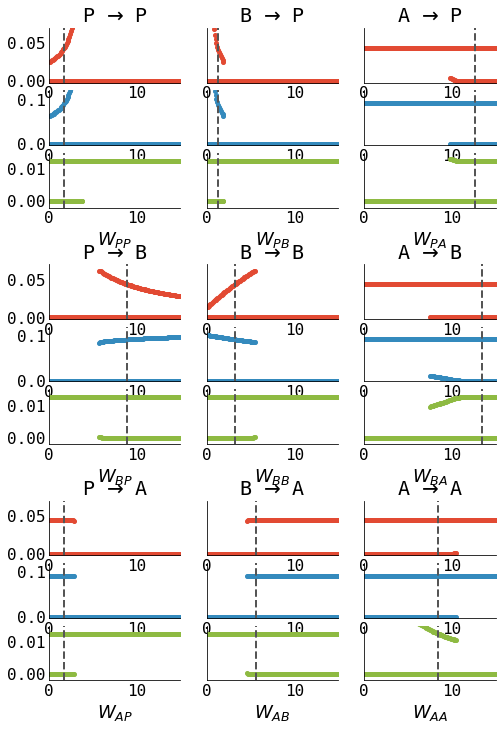

In [9]:
fig, axs = plt.subplots(
    nrows=11,
    ncols=3,
    figsize=(8, 12),
    sharex=False,
    sharey="row",
    gridspec_kw={"height_ratios": [1, 1, 1, 0.75, 1, 1, 1, 0.75, 1, 1, 1]},
)
for i in range(3):
    axs[3, i].axis("off")
    axs[7, i].axis("off")

nodes = {0: "P", 1: "B", 2: "A"}
colors = ["C0", "C1", "C5"]
maxs = [0.07, 0.12, 0.015]

for tt in bif_wrt_conn["to"]:
    for ff in bif_wrt_conn["from"]:
        for ii, node in enumerate(bif_wrt_conn["node"]):
            ax = axs[tt * 4 + ii, ff]
            ax.plot(
                bif_wrt_conn["connectivity"].values,
                bif_wrt_conn.sel({"node": node, "to": tt, "from": ff}),
                "o",
                color=colors[ii],
                markersize=4,
            )
            ax.set_xlim([0, 15])
            ax.set_ylim([-0.002, maxs[ii]])
            # ax.set_ylabel(f"{node.values} [kHz]")
            ax.axvline(
                HIPPOCAMPUS_NODE_DEFAULT_CONNECTIVITY[int(tt), int(ff)] / 1000.0,
                linestyle="--",
                color="#555555",
            )
            sns.despine(ax=ax)
            if ii == 2:
                ax.set_xlabel(
                    fr"$W_{{{nodes[int(tt.values)]}{nodes[int(ff.values)]}}}$"
                )
            if ii == 0:
                ax.set_title(fr"{nodes[int(ff.values)]} $\to$ {nodes[int(tt.values)]}")

plt.subplots_adjust(hspace=0.15, wspace=0.2)

## Profit

We got same figures, all good.